In [1]:
import notebook_env
import importlib
importlib.reload(notebook_env)
from notebook_env import *

In [2]:
importlib.reload(refine_train)
importlib.reload(ode_models)
importlib.reload(odenet_cifar10)
importlib.reload(datasets)

<module 'odenet.datasets' from '/home/ubuntu/afq_odenet/ODENet/odenet/datasets.py'>

# Refinement with Euler and RK4

In [3]:
legend_name = lambda fname : re.search(r"ARCH(.*)", fname)[1]

In [4]:
dirs = glob('results/*CIFAR10-*Backprop*')
dirs = sorted(dirs, key = lambda x : os.stat(x).st_mtime)[:]
DEV = "cuda:3"
results = { name: torch.load(name, map_location={f"cuda:{i}":DEV for i in range(4)}) for name in dirs }
dirs

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'odenet.ode_models.ShallowConv2DODE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'odenet.ode_models.BatchNorm2DODE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'odenet.ode_models.ODEStitch' has changed. you can retrieve the original source code by accessing the o

['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet

In [5]:
df = pd.DataFrame(columns=["model", "scheme", "variant", "time_d","refine epochs","final_time_d","depth","nsteps","accuracy","final time/epoch (S)", "total time (m)"])
for name, result in results.items():
    try:
        args = PostPack(name)
    except Exception as e:
        print(name)
        raise e
    if not args.model == "SingleSegment":
        continue
    if len(result.test_acc) < 159:
        acc = "NaN"
    else:
        acc = max(list(zip(*result.test_acc))[1])
    if not args.use_skip_init:
        var = "BatchNorm"
    else:
        var = "SkipInit"

    try:
        df.loc[len(df)] = \
        [args.model, args.scheme, var, args.initial_time_d, args.refine, args.final_time_d, args.final_time_d*2*3 + 1 + 2 + 2 + 1,
                    args.n_steps_per, acc, result.epoch_times[-1], sum(result.epoch_times)/60.0]
    except:
        print(result.epoch_times)
df.sort_values('accuracy')


,model,scheme,variant,time_d,refine epochs,final_time_d,depth,nsteps,accuracy,final time/epoch (S),total time (m)
34,SingleSegment,euler,SkipInit,12,[],12,78,1,0.9054,46.681769,133.127765
0,SingleSegment,euler,BatchNorm,1,[],1,12,1,0.9060,9.820485,26.063286
37,SingleSegment,euler,SkipInit,2,[],2,18,1,0.9083,11.253361,30.648844
1,SingleSegment,rk4_classic,BatchNorm,1,[],1,12,1,0.9091,14.865958,43.555413
36,SingleSegment,rk4_classic,SkipInit,12,[],12,78,1,0.9091,132.893103,357.856191
...,...,...,...,...,...,...,...,...,...,...,...
58,SingleSegment,rk4_classic,BatchNorm,1,"[20, 40, 60, 70, 80]",32,198,1,0.9362,363.464369,566.020439
52,SingleSegment,euler,BatchNorm,32,[],32,198,1,0.9365,99.543711,267.190840
53,SingleSegment,euler,BatchNorm,32,[],32,198,1,0.9372,98.692015,272.149501
54,SingleSegment,euler,BatchNorm,32,[],32,198,1,0.9385,140.079417,371.667098


In [6]:
rk4_vals = df.loc[df.final_time_d==32].loc[df.scheme=="rk4_classic"].sort_values('accuracy')
rk4_vals
euler_vals = df.loc[df.final_time_d==32].loc[df.scheme=="euler"].sort_values('accuracy')
euler_vals

,model,scheme,variant,time_d,refine epochs,final_time_d,depth,nsteps,accuracy,final time/epoch (S),total time (m)
50,SingleSegment,euler,BatchNorm,32,[],32,198,1,0.9331,98.514882,266.026712
51,SingleSegment,euler,BatchNorm,32,[],32,198,1,0.9331,101.398200,266.768523
49,SingleSegment,euler,BatchNorm,32,[],32,198,1,0.9333,101.433061,264.360573
22,SingleSegment,euler,BatchNorm,1,"[10, 20, 30, 40, 50]",32,198,1,0.9354,124.184268,274.393866
48,SingleSegment,euler,BatchNorm,32,[],32,198,1,0.9355,100.750900,274.961498
52,SingleSegment,euler,BatchNorm,32,[],32,198,1,0.9365,99.543711,267.190840
53,SingleSegment,euler,BatchNorm,32,[],32,198,1,0.9372,98.692015,272.149501
54,SingleSegment,euler,BatchNorm,32,[],32,198,1,0.9385,140.079417,371.667098


In [9]:
refine_train.count_parameters(results[ 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl'].model_list[-1])

3191450

In [10]:
n = 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl'
for m in results[n].model_list:
    print(refine_train.count_parameters(m))

170810
268250
463130
852890
1632410
3191450


In [7]:
rk4_vals.accuracy.mean(), rk4_vals.accuracy.min(), rk4_vals.accuracy.max(), 

(0.9341714285714285, 0.9329, 0.9362)

In [8]:
euler_vals.accuracy.mean(), euler_vals.accuracy.max(), euler_vals.accuracy.min(), 

(0.935325, 0.9385, 0.9331)

In [7]:
print(_.to_latex(index=False))

\begin{tabular}{llllllllrrr}
\toprule
         model &       scheme &    variant & time\_d &         refine epochs & final\_time\_d & depth & nsteps &  accuracy &  final time/epoch (S) &  total time (m) \\
\midrule
 SingleSegment &        euler &  BatchNorm &      1 &  [10, 20, 30, 40, 50] &           32 &   198 &      1 &    0.9354 &            124.184268 &      274.393866 \\
 SingleSegment &  rk4\_classic &  BatchNorm &      1 &  [20, 40, 60, 70, 80] &           32 &   198 &      1 &    0.9349 &            350.464674 &      559.388820 \\
         Wide2 &        euler &   SkipInit &      1 &  [20, 40, 50, 60, 70] &           32 &   198 &      1 &    0.9491 &            144.838942 &      249.692878 \\
 SingleSegment &        euler &  BatchNorm &     32 &                    [] &           32 &   198 &      1 &    0.9355 &            100.750900 &      274.961498 \\
\bottomrule
\end{tabular}



results/odenet-CIFAR10-Wide2-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-32-LEARN-0.1-160-[40, 80]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9223


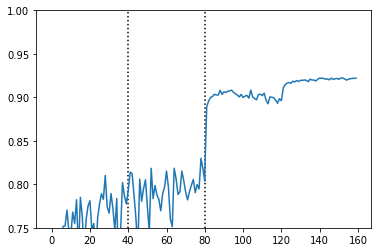

results/odenet-CIFAR10-Wide2-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-32-LEARN-0.1-160-[20, 50, 80]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9257


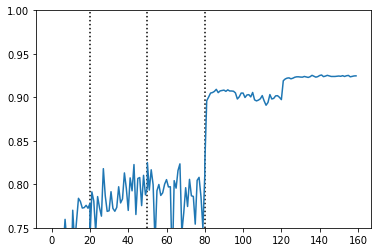

results/odenet-CIFAR10-Wide2-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-32-LEARN-0.1-160-[40, 80]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9226


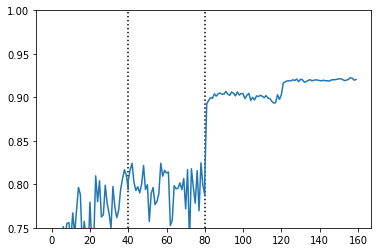

results/odenet-CIFAR10-Wide2-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-32-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9308


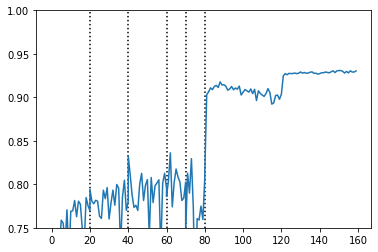

results/odenet-CIFAR10-Wide2-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-32-LEARN-0.1-160-[20, 50, 80]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9267


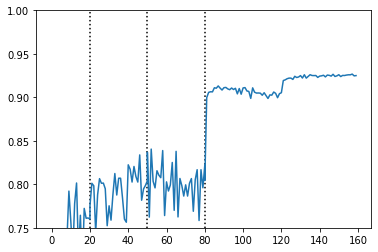

results/odenet-CIFAR10-Wide2-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-32-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9202


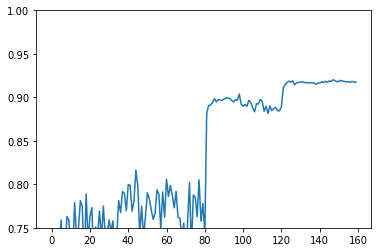

results/odenet-CIFAR10-Wide2-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-32-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9301


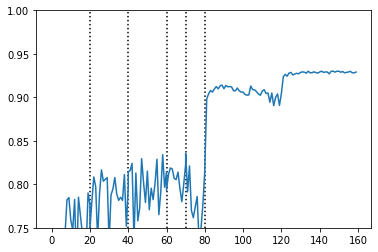

results/odenet-CIFAR10-Wide2-ARCH-16-ode-NoSkip-euler-8-1.0-1-piecewise-32-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9199


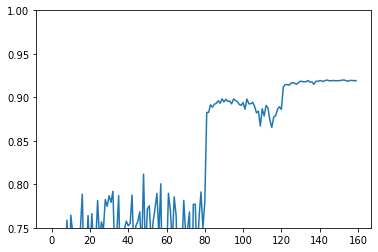

ValueError: not enough values to unpack (expected 2, got 0)

In [175]:
for name, result in results.items():
    #plt.plot(result.train_acc, label=legend_name(name))
    args = PostPack(name)
    if not args.model == "Wide2": continue
    #if not args.use_skip_init: continue
    #if not args.alpha == "32": continue
    x,y = zip(*result.test_acc)
    plt.figure()
    plt.plot(x,y, '-', label=legend_name(name))
    try:
        x,y = zip(*result.train_acc)
        plt.plot(x,y, '--', label=legend_name(name))
    except: pass
    print((name),
          max(list(zip(*result.test_acc))[1]),)
          #max(list(zip(*result.train_acc))[1]))
    plt.vlines(args.refine,0,1, linestyle='dotted')
    plt.ylim(0.75,1)
    plt.show()
    plt.close('all')
    # plt.legend(loc=(0,-0.8))

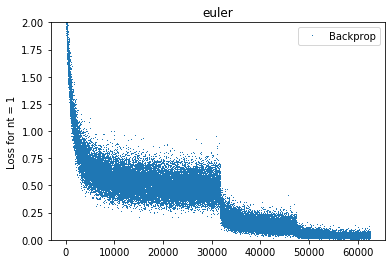

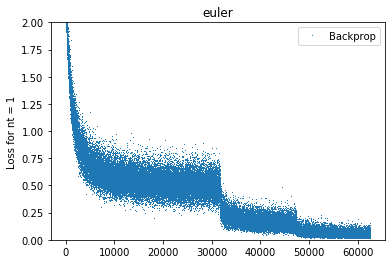

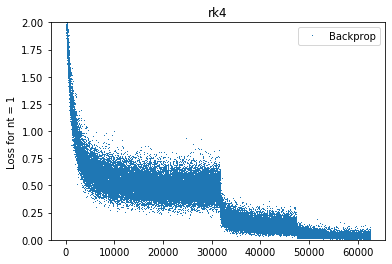

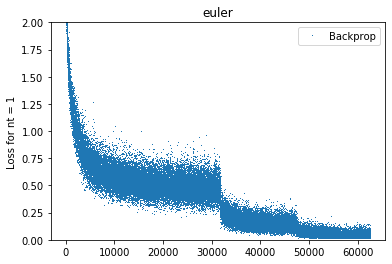

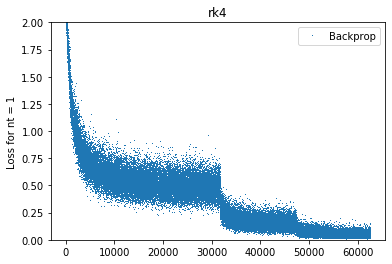

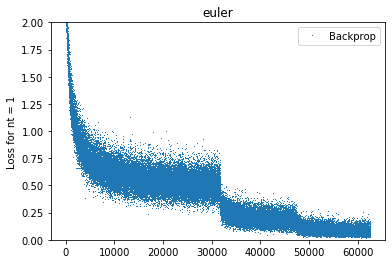

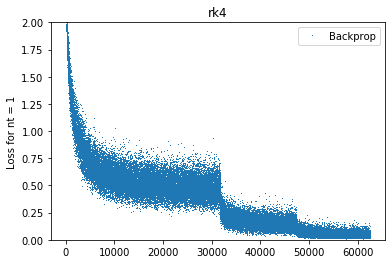

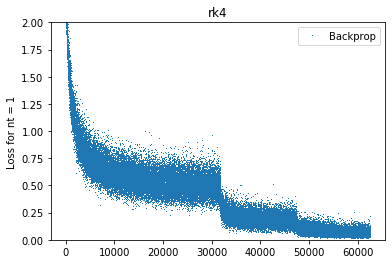

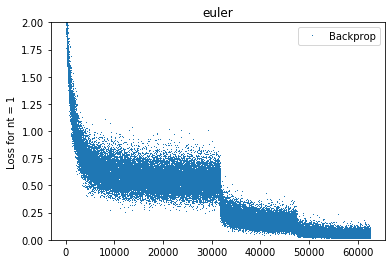

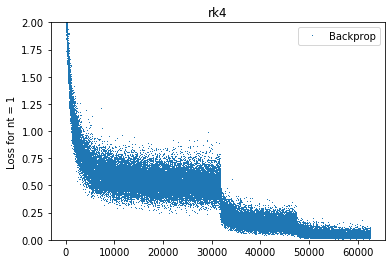

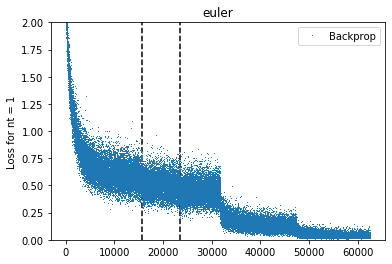

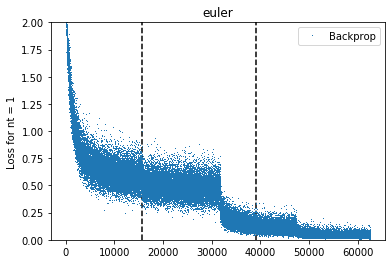

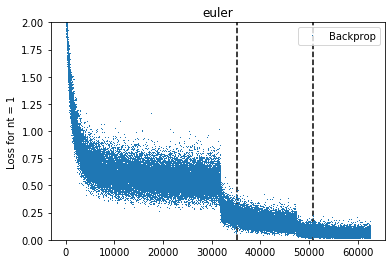

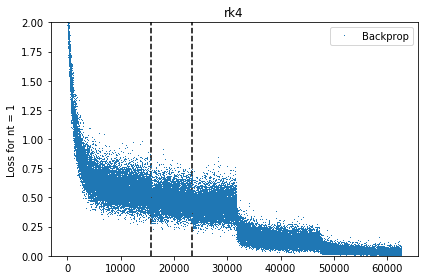

In [62]:
# plt.figure(figsize=(8,8))
for i,(name, result) in enumerate(results.items()):
    if "euler" in name:
        horiz = 0
    else:
        horiz = 1
    args = PostPack(name)
    if not args.use_skip_init: continue
    vert = 0
    # plt.subplot(3,2,1+horiz+2*vert)
    plt.figure()
    if horiz==0 and vert==0:
        plt.title("euler")
    if horiz==1 and vert==0:
        plt.title("rk4")
    if vert==2:
        plt.xlabel("step number")
    plt.ylabel(f"Loss for nt = { vert+1}")
    plt.plot(result.losses,
             '-' if "Adjoint" in name else ',',
             label="Adjoint" if "Adjoint" in name else "Backprop")
    plt.vlines(result.refine_steps, 0,2, linestyle='dashed')
    plt.legend()
    plt.ylim(0.,2)
plt.tight_layout()


# Plot their weights

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30, 40, 50]-0.1-Backprop-NormalInit-SEED-1.pkl


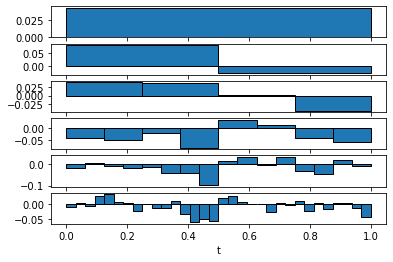

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl


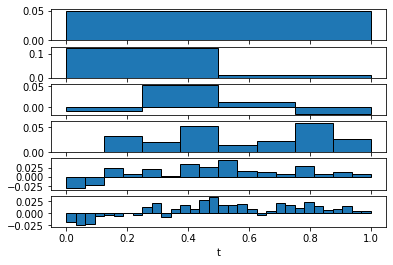

results/odenet-CIFAR10-Wide2-ARCH-16-ode-SkipInit-euler-1-4.0-1-piecewise-32-LEARN-0.1-160-[20, 40, 50, 60, 70]-0.1-Backprop-NormalInit-SEED-1.pkl


AttributeError: 'ODEStitch' object has no attribute 'net'

In [6]:
for name,result in results.items():
    args = PostPack(name)
    if len(args.refine)<5: continue
    i,j=0,0
    for a,b in [(2,2)]: #np.ndindex(result.model_list[0].net[2].net.L1.weight.shape[-2:]):
        print(name)
        plotting.plot_weights_over_time(
            result.model_list,
            lambda x : x.net[5].net.L1.weight[:,i,j,a,b].cpu(),
            lambda x : x.net[5].ts.cpu())


# Manifestation Invariance

In [38]:
sdb = SimDataDB("results/manifestation_study.sqlite")

In [39]:
refset,trainset,trainloader,testset,testloader = \
    datasets.get_dataset("CIFAR10",root='../data/')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [40]:
@sdb.Decorate(
    "fmnist",
    [("network","STRING"),("scheme","STRING"),("num_time","INT"),],
    [("train_acc","INT")])
@torch.no_grad()
def calc_acc_for_scheme_nt(name, scheme, nt):
    mod = results[name].model_list[-1]
    mod.eval()
    set_ode_config(mod, nt, scheme)
    return [refine_train.calculate_accuracy(mod, testloader)]

CREATE TABLE IF NOT EXISTS fmnist ( network STRING, scheme STRING, num_time INT, train_acc INT, timestamp VARCHAR(30), runtime FLOAT );


In [44]:
test_sweep = defaultdict( lambda : {} )
with torch.no_grad():
    for name, result in results.items():
        if not "SingleSegment" in name: continue
        args = PostPack(name)
        if args.final_time_d != 32: continue
        accs_for_scheme = {}
        for scheme in ('euler', 'midpoint','rk4','rk4_classic'):
            accs = []
            nts = range(1, 41, 1)
            nts = range(1,11)
            for nt in progress( nts, f"{legend_name(name)}, {scheme}"):
                accs.append((nt, calc_acc_for_scheme_nt(name, scheme, nt)[0]))
            accs_for_scheme[scheme] = accs
        test_sweep[name].update(accs_for_scheme)


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30, 40, 50]-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 10/10 [00:00<00:00, 1971.93it/s]

-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30, 40, 50]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 10/10 [00:00<00:00, 1956.12it/s]

-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30, 40, 50]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 10/10 [00:00<00:00, 1940.73it/s]

-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30, 40, 50]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic: 100%|██████████| 10/10 [00:00<00:00, 627.20it/s]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 10/10 [00:00<00:00, 574.04it/s]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 10/10

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 4, 0.1182, datetime.datetime(2020, 6, 2, 4, 35, 38, 559892), 2.32586407661438]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  50%|█████     | 5/10 [00:05<00:06,  1.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 5, 0.1034, datetime.datetime(2020, 6, 2, 4, 35, 40, 899946), 2.793660879135132]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  60%|██████    | 6/10 [00:08<00:07,  1.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 6, 0.2127, datetime.datetime(2020, 6, 2, 4, 35, 43, 704076), 3.2137224674224854]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  70%|███████   | 7/10 [00:12<00:07,  2.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 7, 0.2402, datetime.datetime(2020, 6, 2, 4, 35, 46, 928358), 3.6988093852996826]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  80%|████████  | 8/10 [00:16<00:05,  2.95s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 8, 0.1817, datetime.datetime(2020, 6, 2, 4, 35, 50, 637843), 4.199314117431641]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  90%|█████████ | 9/10 [00:21<00:03,  3.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 9, 0.2307, datetime.datetime(2020, 6, 2, 4, 35, 54, 850640), 4.873664617538452]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4: 100%|██████████| 10/10 [00:00<00:00, 390.95it/s]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic: 100%|██████████| 10/10 [00:00<00:00, 397.38it/s]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, euler: 100%|██████████| 10/10 [00:00<00:00, 394.17it/s]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 10, 0.455, datetime.datetime(2020, 6, 2, 4, 35, 59, 735139), 5.086824893951416]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  10%|█         | 1/10 [00:01<00:14,  1.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 1, 0.1278, datetime.datetime(2020, 6, 2, 4, 36, 4, 916525), 1.5504989624023438]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  20%|██        | 2/10 [00:02<00:12,  1.52s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 2, 0.1072, datetime.datetime(2020, 6, 2, 4, 36, 6, 478158), 1.407254695892334]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  30%|███       | 3/10 [00:04<00:11,  1.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 3, 0.1, datetime.datetime(2020, 6, 2, 4, 36, 7, 896535), 1.9376816749572754]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  40%|████      | 4/10 [00:07<00:11,  1.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 4, 0.1196, datetime.datetime(2020, 6, 2, 4, 36, 9, 844871), 2.258345603942871]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  50%|█████     | 5/10 [00:10<00:10,  2.14s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 5, 0.1327, datetime.datetime(2020, 6, 2, 4, 36, 12, 115417), 2.8397016525268555]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  60%|██████    | 6/10 [00:13<00:09,  2.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 6, 0.1647, datetime.datetime(2020, 6, 2, 4, 36, 14, 965593), 3.3138558864593506]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  70%|███████   | 7/10 [00:17<00:08,  2.88s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 7, 0.1929, datetime.datetime(2020, 6, 2, 4, 36, 18, 290621), 3.783226490020752]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  80%|████████  | 8/10 [00:22<00:07,  3.70s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 8, 0.2889, datetime.datetime(2020, 6, 2, 4, 36, 22, 84679), 5.585785150527954]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  90%|█████████ | 9/10 [00:32<00:05,  5.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 9, 0.3482, datetime.datetime(2020, 6, 2, 4, 36, 27, 681154), 10.089723825454712]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint: 100%|██████████| 10/10 [00:44<00:00,  4.42s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4: 100%|██████████| 10/10 [00:00<00:00, 378.30it/s]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic: 100%|██████████| 10/10 [00:00<00:00, 384.34it/s]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 10, 0.2489, datetime.datetime(2020, 6, 2, 4, 36, 37, 782004), 11.3585786819458]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 1, 0.1009, datetime.datetime(2020, 6, 2, 4, 36, 49, 209563), 1.3499619960784912]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  20%|██        | 2/10 [00:03<00:12,  1.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 2, 0.1184, datetime.datetime(2020, 6, 2, 4, 36, 50, 569992), 1.9881715774536133]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  30%|███       | 3/10 [00:06<00:13,  1.93s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 3, 0.1273, datetime.datetime(2020, 6, 2, 4, 36, 52, 572028), 2.7981503009796143]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  40%|████      | 4/10 [00:09<00:13,  2.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 4, 0.1027, datetime.datetime(2020, 6, 2, 4, 36, 55, 380656), 3.2195992469787598]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  50%|█████     | 5/10 [00:13<00:14,  2.89s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 5, 0.1158, datetime.datetime(2020, 6, 2, 4, 36, 58, 611128), 4.223269701004028]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  60%|██████    | 6/10 [00:18<00:13,  3.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 6, 0.1925, datetime.datetime(2020, 6, 2, 4, 37, 2, 844941), 4.6153404712677]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  70%|███████   | 7/10 [00:23<00:12,  4.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 7, 0.2218, datetime.datetime(2020, 6, 2, 4, 37, 7, 470914), 5.505227327346802]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  80%|████████  | 8/10 [00:30<00:09,  4.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 8, 0.2156, datetime.datetime(2020, 6, 2, 4, 37, 12, 986793), 6.388869762420654]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  90%|█████████ | 9/10 [00:36<00:05,  5.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 9, 0.2795, datetime.datetime(2020, 6, 2, 4, 37, 19, 386374), 6.812373638153076]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, euler: 100%|██████████| 10/10 [00:44<00:00,  4.46s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 10, 0.373, datetime.datetime(2020, 6, 2, 4, 37, 26, 209846), 7.557399749755859]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  10%|█         | 1/10 [00:01<00:15,  1.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 1, 0.0861, datetime.datetime(2020, 6, 2, 4, 37, 33, 780501), 1.724459171295166]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  20%|██        | 2/10 [00:04<00:16,  2.07s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 2, 0.1199, datetime.datetime(2020, 6, 2, 4, 37, 35, 516107), 2.834321975708008]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  30%|███       | 3/10 [00:08<00:18,  2.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 3, 0.1123, datetime.datetime(2020, 6, 2, 4, 37, 38, 360817), 3.7444424629211426]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  40%|████      | 4/10 [00:13<00:20,  3.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 4, 0.131, datetime.datetime(2020, 6, 2, 4, 37, 42, 116409), 5.096614122390747]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  50%|█████     | 5/10 [00:19<00:20,  4.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 5, 0.092, datetime.datetime(2020, 6, 2, 4, 37, 47, 225081), 5.975968360900879]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  60%|██████    | 6/10 [00:26<00:20,  5.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 6, 0.1952, datetime.datetime(2020, 6, 2, 4, 37, 53, 211924), 7.293294191360474]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  70%|███████   | 7/10 [00:34<00:17,  6.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 7, 0.2155, datetime.datetime(2020, 6, 2, 4, 38, 0, 516188), 8.126466512680054]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  80%|████████  | 8/10 [00:44<00:14,  7.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 8, 0.2341, datetime.datetime(2020, 6, 2, 4, 38, 8, 653489), 9.393885135650635]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  90%|█████████ | 9/10 [00:54<00:08,  8.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 9, 0.4867, datetime.datetime(2020, 6, 2, 4, 38, 18, 58384), 10.600821495056152]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint: 100%|██████████| 10/10 [01:06<00:00,  6.64s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 10, 0.2476, datetime.datetime(2020, 6, 2, 4, 38, 28, 669926), 11.484638214111328]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  10%|█         | 1/10 [00:02<00:23,  2.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 1, 0.1001, datetime.datetime(2020, 6, 2, 4, 38, 40, 168307), 2.6136507987976074]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  20%|██        | 2/10 [00:07<00:25,  3.16s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 2, 0.0903, datetime.datetime(2020, 6, 2, 4, 38, 42, 792862), 4.4018402099609375]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  30%|███       | 3/10 [00:13<00:30,  4.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 3, 0.1074, datetime.datetime(2020, 6, 2, 4, 38, 47, 206641), 6.924978733062744]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  40%|████      | 4/10 [00:22<00:33,  5.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 4, 0.3046, datetime.datetime(2020, 6, 2, 4, 38, 54, 142386), 8.51777696609497]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  50%|█████     | 5/10 [00:33<00:35,  7.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 5, 0.5425, datetime.datetime(2020, 6, 2, 4, 39, 2, 671076), 10.717673063278198]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  60%|██████    | 6/10 [00:45<00:34,  8.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 6, 0.6665, datetime.datetime(2020, 6, 2, 4, 39, 13, 399316), 12.554863452911377]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  70%|███████   | 7/10 [01:00<00:31, 10.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 7, 0.8104, datetime.datetime(2020, 6, 2, 4, 39, 25, 966040), 14.551440000534058]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  80%|████████  | 8/10 [01:16<00:24, 12.31s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 8, 0.856, datetime.datetime(2020, 6, 2, 4, 39, 40, 528409), 16.537644147872925]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  90%|█████████ | 9/10 [01:35<00:14, 14.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 9, 0.8924, datetime.datetime(2020, 6, 2, 4, 39, 57, 77304), 18.790415048599243]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4: 100%|██████████| 10/10 [01:56<00:00, 11.65s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 10, 0.9107, datetime.datetime(2020, 6, 2, 4, 40, 15, 878464), 20.756224393844604]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  10%|█         | 1/10 [00:02<00:23,  2.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 1, 0.1, datetime.datetime(2020, 6, 2, 4, 40, 36, 648496), 2.6427597999572754]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  20%|██        | 2/10 [00:07<00:25,  3.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 2, 0.1318, datetime.datetime(2020, 6, 2, 4, 40, 39, 301759), 4.6286070346832275]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  30%|███       | 3/10 [00:13<00:29,  4.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 3, 0.1785, datetime.datetime(2020, 6, 2, 4, 40, 43, 941313), 6.689687490463257]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  40%|████      | 4/10 [00:22<00:33,  5.54s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 4, 0.2408, datetime.datetime(2020, 6, 2, 4, 40, 50, 642053), 8.469444036483765]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  50%|█████     | 5/10 [00:33<00:35,  7.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 5, 0.2171, datetime.datetime(2020, 6, 2, 4, 40, 59, 123137), 10.719833135604858]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  60%|██████    | 6/10 [00:45<00:34,  8.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 6, 0.4291, datetime.datetime(2020, 6, 2, 4, 41, 9, 853522), 12.444167852401733]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  70%|███████   | 7/10 [01:00<00:31, 10.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 7, 0.439, datetime.datetime(2020, 6, 2, 4, 41, 22, 310291), 14.701852083206177]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  80%|████████  | 8/10 [01:16<00:24, 12.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 8, 0.6262, datetime.datetime(2020, 6, 2, 4, 41, 37, 23536), 16.544565439224243]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  90%|█████████ | 9/10 [01:35<00:14, 14.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 9, 0.7164, datetime.datetime(2020, 6, 2, 4, 41, 53, 579192), 18.497791051864624]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic: 100%|██████████| 10/10 [01:55<00:00, 11.60s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 10, 0.7453, datetime.datetime(2020, 6, 2, 4, 42, 12, 88025), 20.517993450164795]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  10%|█         | 1/10 [00:01<00:12,  1.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 1, 0.0956, datetime.datetime(2020, 6, 2, 4, 42, 32, 619672), 1.3702037334442139]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  20%|██        | 2/10 [00:03<00:12,  1.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 2, 0.1183, datetime.datetime(2020, 6, 2, 4, 42, 34, 1028), 1.9817194938659668]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  30%|███       | 3/10 [00:06<00:13,  1.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 3, 0.1007, datetime.datetime(2020, 6, 2, 4, 42, 35, 993941), 2.7291336059570312]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  40%|████      | 4/10 [00:09<00:14,  2.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 4, 0.0997, datetime.datetime(2020, 6, 2, 4, 42, 38, 733785), 3.42059588432312]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  50%|█████     | 5/10 [00:13<00:14,  2.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 5, 0.1269, datetime.datetime(2020, 6, 2, 4, 42, 42, 165021), 4.151382684707642]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  60%|██████    | 6/10 [00:18<00:13,  3.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 6, 0.0936, datetime.datetime(2020, 6, 2, 4, 42, 46, 326815), 4.554576873779297]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  70%|███████   | 7/10 [00:23<00:12,  4.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 7, 0.2732, datetime.datetime(2020, 6, 2, 4, 42, 50, 894457), 5.5829362869262695]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  80%|████████  | 8/10 [00:30<00:09,  4.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 8, 0.2309, datetime.datetime(2020, 6, 2, 4, 42, 56, 489815), 6.269449234008789]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  90%|█████████ | 9/10 [00:37<00:05,  5.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 9, 0.23, datetime.datetime(2020, 6, 2, 4, 43, 2, 769834), 6.992680788040161]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, euler: 100%|██████████| 10/10 [00:44<00:00,  4.45s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 10, 0.2299, datetime.datetime(2020, 6, 2, 4, 43, 9, 773531), 7.3564887046813965]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  10%|█         | 1/10 [00:01<00:15,  1.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 1, 0.1152, datetime.datetime(2020, 6, 2, 4, 43, 17, 143777), 1.711089849472046]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  20%|██        | 2/10 [00:04<00:16,  2.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 2, 0.0979, datetime.datetime(2020, 6, 2, 4, 43, 18, 866073), 2.777008056640625]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  30%|███       | 3/10 [00:08<00:18,  2.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 3, 0.1039, datetime.datetime(2020, 6, 2, 4, 43, 21, 654754), 3.936898708343506]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  40%|████      | 4/10 [00:13<00:20,  3.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 4, 0.0954, datetime.datetime(2020, 6, 2, 4, 43, 25, 604214), 5.001929998397827]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  50%|█████     | 5/10 [00:19<00:20,  4.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 5, 0.1116, datetime.datetime(2020, 6, 2, 4, 43, 30, 618982), 6.154967784881592]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  60%|██████    | 6/10 [00:27<00:20,  5.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 6, 0.165, datetime.datetime(2020, 6, 2, 4, 43, 36, 785408), 7.575885534286499]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  70%|███████   | 7/10 [00:36<00:19,  6.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 7, 0.1477, datetime.datetime(2020, 6, 2, 4, 43, 44, 372696), 9.596227407455444]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  80%|████████  | 8/10 [00:47<00:15,  7.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 8, 0.2463, datetime.datetime(2020, 6, 2, 4, 43, 53, 980006), 10.944194793701172]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  90%|█████████ | 9/10 [01:00<00:09,  9.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 9, 0.4442, datetime.datetime(2020, 6, 2, 4, 44, 4, 935313), 12.289868116378784]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint: 100%|██████████| 10/10 [01:13<00:00,  7.37s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 10, 0.4192, datetime.datetime(2020, 6, 2, 4, 44, 17, 236050), 13.615587949752808]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  10%|█         | 1/10 [00:03<00:27,  3.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 1, 0.0972, datetime.datetime(2020, 6, 2, 4, 44, 30, 866582), 3.0707383155822754]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  20%|██        | 2/10 [00:08<00:29,  3.70s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 2, 0.1069, datetime.datetime(2020, 6, 2, 4, 44, 33, 948038), 5.14768123626709]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  30%|███       | 3/10 [00:16<00:34,  4.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 3, 0.1287, datetime.datetime(2020, 6, 2, 4, 44, 39, 108237), 7.896643400192261]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  40%|████      | 4/10 [00:26<00:39,  6.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 4, 0.2057, datetime.datetime(2020, 6, 2, 4, 44, 47, 15607), 10.287906408309937]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  50%|█████     | 5/10 [00:38<00:41,  8.31s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 5, 0.4211, datetime.datetime(2020, 6, 2, 4, 44, 57, 314887), 12.361228704452515]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  60%|██████    | 6/10 [00:53<00:41, 10.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 6, 0.7216, datetime.datetime(2020, 6, 2, 4, 45, 9, 688726), 14.812121391296387]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  70%|███████   | 7/10 [01:11<00:37, 12.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 7, 0.7709, datetime.datetime(2020, 6, 2, 4, 45, 24, 511711), 17.678510427474976]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  80%|████████  | 8/10 [01:31<00:29, 14.68s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 8, 0.8644, datetime.datetime(2020, 6, 2, 4, 45, 42, 202959), 19.777478456497192]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  90%|█████████ | 9/10 [01:53<00:16, 16.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 9, 0.8939, datetime.datetime(2020, 6, 2, 4, 46, 1, 993315), 22.261948347091675]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4: 100%|██████████| 10/10 [02:17<00:00, 13.79s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 10, 0.9118, datetime.datetime(2020, 6, 2, 4, 46, 24, 267397), 24.443889617919922]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  10%|█         | 1/10 [00:02<00:26,  2.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 1, 0.1021, datetime.datetime(2020, 6, 2, 4, 46, 48, 724637), 2.956658363342285]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  20%|██        | 2/10 [00:08<00:29,  3.70s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 2, 0.102, datetime.datetime(2020, 6, 2, 4, 46, 51, 693999), 5.391082286834717]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  30%|███       | 3/10 [00:16<00:34,  4.93s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 3, 0.1024, datetime.datetime(2020, 6, 2, 4, 46, 57, 95469), 7.807748079299927]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  40%|████      | 4/10 [00:26<00:39,  6.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 4, 0.1923, datetime.datetime(2020, 6, 2, 4, 47, 4, 914153), 10.239702701568604]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  50%|█████     | 5/10 [00:38<00:41,  8.24s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 5, 0.1841, datetime.datetime(2020, 6, 2, 4, 47, 15, 165704), 12.206762552261353]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  60%|██████    | 6/10 [00:53<00:41, 10.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 6, 0.4545, datetime.datetime(2020, 6, 2, 4, 47, 27, 383334), 15.069446563720703]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  70%|███████   | 7/10 [01:10<00:37, 12.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 7, 0.5489, datetime.datetime(2020, 6, 2, 4, 47, 42, 463478), 17.108196258544922]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  80%|████████  | 8/10 [01:30<00:29, 14.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 8, 0.5882, datetime.datetime(2020, 6, 2, 4, 47, 59, 582825), 19.924028158187866]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  90%|█████████ | 9/10 [01:52<00:16, 16.82s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 9, 0.7316, datetime.datetime(2020, 6, 2, 4, 48, 19, 517900), 21.95227360725403]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic: 100%|██████████| 10/10 [02:17<00:00, 13.75s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 10, 0.7688, datetime.datetime(2020, 6, 2, 4, 48, 41, 481136), 24.7295503616333]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  10%|█         | 1/10 [00:01<00:13,  1.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 1, 0.1045, datetime.datetime(2020, 6, 2, 4, 49, 6, 224165), 1.4781172275543213]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  20%|██        | 2/10 [00:03<00:13,  1.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 2, 0.1286, datetime.datetime(2020, 6, 2, 4, 49, 7, 713240), 2.286278486251831]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  30%|███       | 3/10 [00:06<00:15,  2.16s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 3, 0.1221, datetime.datetime(2020, 6, 2, 4, 49, 10, 11037), 3.1574883460998535]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  40%|████      | 4/10 [00:10<00:15,  2.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 4, 0.1488, datetime.datetime(2020, 6, 2, 4, 49, 13, 181406), 3.4987292289733887]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  50%|█████     | 5/10 [00:15<00:16,  3.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 5, 0.1095, datetime.datetime(2020, 6, 2, 4, 49, 16, 690981), 4.915268898010254]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  60%|██████    | 6/10 [00:21<00:16,  4.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 6, 0.1363, datetime.datetime(2020, 6, 2, 4, 49, 21, 617185), 5.854307413101196]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  70%|███████   | 7/10 [00:27<00:14,  4.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 7, 0.2695, datetime.datetime(2020, 6, 2, 4, 49, 27, 482325), 6.641266822814941]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  80%|████████  | 8/10 [00:35<00:11,  5.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 8, 0.1893, datetime.datetime(2020, 6, 2, 4, 49, 34, 135890), 7.438734769821167]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  90%|█████████ | 9/10 [00:43<00:06,  6.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 9, 0.3043, datetime.datetime(2020, 6, 2, 4, 49, 41, 585230), 8.516934394836426]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, euler: 100%|██████████| 10/10 [00:52<00:00,  5.27s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 10, 0.2395, datetime.datetime(2020, 6, 2, 4, 49, 50, 112907), 8.751834392547607]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  10%|█         | 1/10 [00:01<00:17,  1.95s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 1, 0.1101, datetime.datetime(2020, 6, 2, 4, 49, 58, 878822), 1.9414498805999756]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  20%|██        | 2/10 [00:05<00:18,  2.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 2, 0.0921, datetime.datetime(2020, 6, 2, 4, 50, 0, 831911), 3.268571138381958]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  30%|███       | 3/10 [00:09<00:21,  3.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 3, 0.1118, datetime.datetime(2020, 6, 2, 4, 50, 4, 110940), 4.604972839355469]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  40%|████      | 4/10 [00:15<00:23,  3.89s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 4, 0.1181, datetime.datetime(2020, 6, 2, 4, 50, 8, 728564), 5.900462865829468]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  50%|█████     | 5/10 [00:23<00:24,  4.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 5, 0.1558, datetime.datetime(2020, 6, 2, 4, 50, 14, 641290), 7.299260377883911]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  60%|██████    | 6/10 [00:31<00:24,  6.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 6, 0.1997, datetime.datetime(2020, 6, 2, 4, 50, 21, 951835), 8.610394716262817]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  70%|███████   | 7/10 [00:41<00:21,  7.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 7, 0.1664, datetime.datetime(2020, 6, 2, 4, 50, 30, 573060), 9.958482027053833]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  80%|████████  | 8/10 [00:52<00:16,  8.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 8, 0.2046, datetime.datetime(2020, 6, 2, 4, 50, 40, 542817), 10.691282033920288]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  90%|█████████ | 9/10 [01:05<00:09,  9.58s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 9, 0.2758, datetime.datetime(2020, 6, 2, 4, 50, 51, 244766), 12.644997358322144]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint: 100%|██████████| 10/10 [01:18<00:00,  7.90s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 10, 0.3386, datetime.datetime(2020, 6, 2, 4, 51, 3, 900559), 13.934187889099121]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  10%|█         | 1/10 [00:03<00:27,  3.07s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 1, 0.0967, datetime.datetime(2020, 6, 2, 4, 51, 17, 848151), 3.055734634399414]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  20%|██        | 2/10 [00:08<00:30,  3.81s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 2, 0.0812, datetime.datetime(2020, 6, 2, 4, 51, 20, 914763), 5.526005029678345]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  30%|███       | 3/10 [00:16<00:34,  4.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 3, 0.094, datetime.datetime(2020, 6, 2, 4, 51, 26, 452193), 7.6617515087127686]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  40%|████      | 4/10 [00:26<00:39,  6.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 4, 0.3497, datetime.datetime(2020, 6, 2, 4, 51, 34, 124895), 10.24971318244934]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  50%|█████     | 5/10 [00:39<00:42,  8.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 5, 0.3617, datetime.datetime(2020, 6, 2, 4, 51, 44, 385530), 12.694596290588379]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  60%|██████    | 6/10 [00:54<00:41, 10.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 6, 0.6746, datetime.datetime(2020, 6, 2, 4, 51, 57, 91453), 15.116671800613403]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  70%|███████   | 7/10 [01:11<00:37, 12.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 7, 0.7228, datetime.datetime(2020, 6, 2, 4, 52, 12, 219208), 17.137385606765747]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  80%|████████  | 8/10 [01:31<00:29, 14.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 8, 0.8213, datetime.datetime(2020, 6, 2, 4, 52, 29, 367942), 19.990139484405518]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  90%|█████████ | 9/10 [01:53<00:17, 17.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 9, 0.894, datetime.datetime(2020, 6, 2, 4, 52, 49, 368978), 22.344446897506714]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4: 100%|██████████| 10/10 [02:18<00:00, 13.82s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 10, 0.917, datetime.datetime(2020, 6, 2, 4, 53, 11, 724411), 24.26713490486145]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  10%|█         | 1/10 [00:03<00:27,  3.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 1, 0.0979, datetime.datetime(2020, 6, 2, 4, 53, 36, 5349), 3.030980348587036]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  20%|██        | 2/10 [00:08<00:30,  3.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 2, 0.1145, datetime.datetime(2020, 6, 2, 4, 53, 39, 49010), 5.537501096725464]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  30%|███       | 3/10 [00:16<00:34,  4.99s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 3, 0.1133, datetime.datetime(2020, 6, 2, 4, 53, 44, 597629), 7.775465965270996]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  40%|████      | 4/10 [00:26<00:39,  6.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 4, 0.1309, datetime.datetime(2020, 6, 2, 4, 53, 52, 383671), 10.225220203399658]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  50%|█████     | 5/10 [00:39<00:41,  8.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 5, 0.2771, datetime.datetime(2020, 6, 2, 4, 54, 2, 621203), 12.625244140625]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  60%|██████    | 6/10 [00:53<00:41, 10.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 6, 0.5744, datetime.datetime(2020, 6, 2, 4, 54, 15, 257006), 14.615676403045654]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  70%|███████   | 7/10 [01:11<00:37, 12.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 7, 0.4613, datetime.datetime(2020, 6, 2, 4, 54, 29, 883555), 17.403953790664673]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  80%|████████  | 8/10 [01:31<00:29, 14.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 8, 0.6294, datetime.datetime(2020, 6, 2, 4, 54, 47, 298369), 19.829617500305176]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  90%|█████████ | 9/10 [01:52<00:16, 16.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 9, 0.7243, datetime.datetime(2020, 6, 2, 4, 55, 7, 139074), 21.61021661758423]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic: 100%|██████████| 10/10 [02:17<00:00, 13.73s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 10, 0.7532, datetime.datetime(2020, 6, 2, 4, 55, 28, 760152), 24.579768419265747]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  10%|█         | 1/10 [00:01<00:13,  1.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 1, 0.1572, datetime.datetime(2020, 6, 2, 4, 55, 53, 353819), 1.435546875]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  20%|██        | 2/10 [00:03<00:13,  1.70s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 2, 0.1488, datetime.datetime(2020, 6, 2, 4, 55, 54, 802595), 2.280670166015625]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  30%|███       | 3/10 [00:06<00:14,  2.14s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 3, 0.1047, datetime.datetime(2020, 6, 2, 4, 55, 57, 95601), 3.142071008682251]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  40%|████      | 4/10 [00:10<00:16,  2.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 4, 0.1612, datetime.datetime(2020, 6, 2, 4, 56, 0, 248786), 4.02454948425293]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  50%|█████     | 5/10 [00:15<00:16,  3.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 5, 0.1048, datetime.datetime(2020, 6, 2, 4, 56, 4, 285518), 4.893121957778931]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  60%|██████    | 6/10 [00:21<00:16,  4.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 6, 0.1302, datetime.datetime(2020, 6, 2, 4, 56, 9, 189592), 5.758704662322998]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  70%|███████   | 7/10 [00:28<00:14,  4.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 7, 0.1234, datetime.datetime(2020, 6, 2, 4, 56, 14, 959205), 6.603996276855469]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  80%|████████  | 8/10 [00:35<00:10,  5.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 8, 0.2072, datetime.datetime(2020, 6, 2, 4, 56, 21, 576044), 6.829959154129028]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  90%|█████████ | 9/10 [00:43<00:06,  6.31s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 9, 0.3369, datetime.datetime(2020, 6, 2, 4, 56, 28, 416867), 8.32933235168457]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, euler: 100%|██████████| 10/10 [00:52<00:00,  5.26s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 10, 0.2561, datetime.datetime(2020, 6, 2, 4, 56, 36, 757050), 9.224572896957397]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  10%|█         | 1/10 [00:01<00:17,  1.95s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 1, 0.1046, datetime.datetime(2020, 6, 2, 4, 56, 45, 995229), 1.9383177757263184]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  20%|██        | 2/10 [00:05<00:18,  2.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 2, 0.1089, datetime.datetime(2020, 6, 2, 4, 56, 47, 944974), 3.2915029525756836]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  30%|███       | 3/10 [00:09<00:21,  3.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 3, 0.1108, datetime.datetime(2020, 6, 2, 4, 56, 51, 247622), 4.666064023971558]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  40%|████      | 4/10 [00:15<00:23,  3.93s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 4, 0.1017, datetime.datetime(2020, 6, 2, 4, 56, 55, 924893), 5.97086501121521]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  50%|█████     | 5/10 [00:23<00:24,  4.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 5, 0.0992, datetime.datetime(2020, 6, 2, 4, 57, 1, 908505), 7.2760233879089355]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  60%|██████    | 6/10 [00:31<00:24,  6.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 6, 0.1054, datetime.datetime(2020, 6, 2, 4, 57, 9, 194895), 8.67958402633667]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  70%|███████   | 7/10 [00:41<00:21,  7.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 7, 0.1569, datetime.datetime(2020, 6, 2, 4, 57, 17, 885458), 9.993882894515991]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  80%|████████  | 8/10 [00:52<00:16,  8.23s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 8, 0.2128, datetime.datetime(2020, 6, 2, 4, 57, 27, 890298), 10.514901876449585]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  90%|█████████ | 9/10 [01:05<00:09,  9.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 9, 0.2565, datetime.datetime(2020, 6, 2, 4, 57, 38, 418333), 12.609584331512451]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint: 100%|██████████| 10/10 [01:18<00:00,  7.90s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 10, 0.1965, datetime.datetime(2020, 6, 2, 4, 57, 51, 38152), 13.935755252838135]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  10%|█         | 1/10 [00:03<00:27,  3.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 1, 0.1006, datetime.datetime(2020, 6, 2, 4, 58, 4, 987489), 3.0410845279693604]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  20%|██        | 2/10 [00:08<00:30,  3.78s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 2, 0.0957, datetime.datetime(2020, 6, 2, 4, 58, 8, 39124), 5.462748289108276]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  30%|███       | 3/10 [00:16<00:35,  5.07s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 3, 0.1085, datetime.datetime(2020, 6, 2, 4, 58, 13, 512332), 8.085377216339111]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  40%|████      | 4/10 [00:27<00:40,  6.70s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 4, 0.256, datetime.datetime(2020, 6, 2, 4, 58, 21, 608559), 10.490118503570557]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  50%|█████     | 5/10 [00:39<00:42,  8.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 5, 0.4206, datetime.datetime(2020, 6, 2, 4, 58, 32, 109916), 12.384113311767578]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  60%|██████    | 6/10 [00:54<00:41, 10.47s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 6, 0.6257, datetime.datetime(2020, 6, 2, 4, 58, 44, 505352), 15.278377294540405]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  70%|███████   | 7/10 [01:12<00:37, 12.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 7, 0.7601, datetime.datetime(2020, 6, 2, 4, 58, 59, 794733), 17.74596381187439]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  80%|████████  | 8/10 [01:32<00:29, 14.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 8, 0.8369, datetime.datetime(2020, 6, 2, 4, 59, 17, 551830), 19.92619490623474]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  90%|█████████ | 9/10 [01:54<00:16, 16.93s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 9, 0.8777, datetime.datetime(2020, 6, 2, 4, 59, 37, 490511), 21.789142608642578]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4: 100%|██████████| 10/10 [02:19<00:00, 13.92s/it]

-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 10, 0.9038, datetime.datetime(2020, 6, 2, 4, 59, 59, 290541), 24.834243535995483]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  10%|█         | 1/10 [00:02<00:26,  2.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 1, 0.1079, datetime.datetime(2020, 6, 2, 5, 0, 24, 139791), 2.9721827507019043]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  20%|██        | 2/10 [00:08<00:29,  3.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 2, 0.1051, datetime.datetime(2020, 6, 2, 5, 0, 27, 123136), 5.3876307010650635]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  30%|███       | 3/10 [00:16<00:34,  4.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 3, 0.1682, datetime.datetime(2020, 6, 2, 5, 0, 32, 522021), 7.794616222381592]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  40%|████      | 4/10 [00:26<00:39,  6.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 4, 0.2065, datetime.datetime(2020, 6, 2, 5, 0, 40, 328430), 10.22911262512207]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  50%|█████     | 5/10 [00:39<00:41,  8.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 5, 0.2271, datetime.datetime(2020, 6, 2, 5, 0, 50, 571379), 12.612014055252075]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  60%|██████    | 6/10 [00:53<00:40, 10.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 6, 0.4018, datetime.datetime(2020, 6, 2, 5, 1, 3, 198818), 14.418617248535156]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  70%|███████   | 7/10 [01:10<00:37, 12.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 7, 0.4558, datetime.datetime(2020, 6, 2, 5, 1, 17, 629929), 17.44737482070923]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  80%|████████  | 8/10 [01:30<00:29, 14.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 8, 0.5462, datetime.datetime(2020, 6, 2, 5, 1, 35, 91873), 19.812334537506104]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  90%|█████████ | 9/10 [01:52<00:16, 16.89s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 9, 0.6112, datetime.datetime(2020, 6, 2, 5, 1, 54, 916935), 22.212878704071045]



-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic: 100%|██████████| 10/10 [02:17<00:00, 13.70s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-32-1.0-1-piecewise-None-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 10, 0.7059, datetime.datetime(2020, 6, 2, 5, 2, 17, 142647), 23.989410877227783]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler:  10%|█         | 1/10 [00:01<00:13,  1.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'euler', 1, 0.1642, datetime.datetime(2020, 6, 2, 5, 2, 41, 149216), 1.5223593711853027]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler:  20%|██        | 2/10 [00:03<00:14,  1.76s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'euler', 2, 0.2168, datetime.datetime(2020, 6, 2, 5, 2, 42, 684006), 2.28743314743042]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler:  30%|███       | 3/10 [00:07<00:15,  2.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'euler', 3, 0.2872, datetime.datetime(2020, 6, 2, 5, 2, 44, 984254), 3.194122076034546]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler:  40%|████      | 4/10 [00:11<00:16,  2.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'euler', 4, 0.4975, datetime.datetime(2020, 6, 2, 5, 2, 48, 189117), 4.0242438316345215]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler:  50%|█████     | 5/10 [00:15<00:16,  3.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'euler', 5, 0.571, datetime.datetime(2020, 6, 2, 5, 2, 52, 224057), 4.904607772827148]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler:  60%|██████    | 6/10 [00:21<00:16,  4.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'euler', 6, 0.6454, datetime.datetime(2020, 6, 2, 5, 2, 57, 140030), 5.763937711715698]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler:  70%|███████   | 7/10 [00:28<00:14,  4.87s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'euler', 7, 0.7719, datetime.datetime(2020, 6, 2, 5, 3, 2, 914925), 6.627112627029419]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler:  80%|████████  | 8/10 [00:35<00:11,  5.63s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'euler', 8, 0.8064, datetime.datetime(2020, 6, 2, 5, 3, 9, 553415), 7.407201290130615]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler:  90%|█████████ | 9/10 [00:44<00:06,  6.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'euler', 9, 0.7943, datetime.datetime(2020, 6, 2, 5, 3, 16, 971834), 8.36398983001709]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, euler: 100%|██████████| 10/10 [00:53<00:00,  5.34s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'euler', 10, 0.8389, datetime.datetime(2020, 6, 2, 5, 3, 25, 348685), 9.193918943405151]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  10%|█         | 1/10 [00:01<00:17,  1.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 1, 0.1274, datetime.datetime(2020, 6, 2, 5, 3, 34, 556541), 1.931868314743042]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  20%|██        | 2/10 [00:05<00:18,  2.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 2, 0.2273, datetime.datetime(2020, 6, 2, 5, 3, 36, 501040), 3.312251091003418]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  30%|███       | 3/10 [00:09<00:20,  2.86s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 3, 0.3736, datetime.datetime(2020, 6, 2, 5, 3, 39, 825370), 4.033573865890503]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  40%|████      | 4/10 [00:15<00:22,  3.82s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 4, 0.592, datetime.datetime(2020, 6, 2, 5, 3, 43, 871683), 6.042921781539917]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  50%|█████     | 5/10 [00:22<00:24,  4.88s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 5, 0.6158, datetime.datetime(2020, 6, 2, 5, 3, 49, 926021), 7.3278725147247314]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  60%|██████    | 6/10 [00:31<00:24,  6.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 6, 0.76, datetime.datetime(2020, 6, 2, 5, 3, 57, 265216), 8.700644731521606]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  70%|███████   | 7/10 [00:41<00:21,  7.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 7, 0.7457, datetime.datetime(2020, 6, 2, 5, 4, 5, 976823), 9.910781860351562]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  80%|████████  | 8/10 [00:52<00:16,  8.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 8, 0.8251, datetime.datetime(2020, 6, 2, 5, 4, 15, 898944), 11.2848219871521]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint:  90%|█████████ | 9/10 [01:05<00:09,  9.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 9, 0.8459, datetime.datetime(2020, 6, 2, 5, 4, 27, 195538), 12.68160629272461]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, midpoint: 100%|██████████| 10/10 [01:19<00:00,  7.93s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'midpoint', 10, 0.8623, datetime.datetime(2020, 6, 2, 5, 4, 39, 887945), 13.917173147201538]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4:  10%|█         | 1/10 [00:03<00:27,  3.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4', 1, 0.0978, datetime.datetime(2020, 6, 2, 5, 4, 53, 818979), 3.077223062515259]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4:  20%|██        | 2/10 [00:08<00:29,  3.70s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4', 2, 0.2294, datetime.datetime(2020, 6, 2, 5, 4, 56, 908549), 5.127683401107788]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4:  30%|███       | 3/10 [00:16<00:34,  4.99s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4', 3, 0.6426, datetime.datetime(2020, 6, 2, 5, 5, 2, 47263), 7.977905750274658]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4:  40%|████      | 4/10 [00:26<00:39,  6.59s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4', 4, 0.8246, datetime.datetime(2020, 6, 2, 5, 5, 10, 36448), 10.306251049041748]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4:  50%|█████     | 5/10 [00:39<00:42,  8.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4', 5, 0.8842, datetime.datetime(2020, 6, 2, 5, 5, 20, 354556), 12.709543466567993]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4:  60%|██████    | 6/10 [00:54<00:41, 10.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4', 6, 0.9112, datetime.datetime(2020, 6, 2, 5, 5, 33, 75973), 15.068112134933472]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4:  70%|███████   | 7/10 [01:11<00:37, 12.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4', 7, 0.9129, datetime.datetime(2020, 6, 2, 5, 5, 48, 154716), 17.5597882270813]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4:  80%|████████  | 8/10 [01:32<00:29, 14.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4', 8, 0.9211, datetime.datetime(2020, 6, 2, 5, 6, 5, 725449), 20.11621880531311]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4:  90%|█████████ | 9/10 [01:53<00:16, 16.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4', 9, 0.9211, datetime.datetime(2020, 6, 2, 5, 6, 25, 852760), 21.764111042022705]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4: 100%|██████████| 10/10 [02:18<00:00, 13.89s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4', 10, 0.9295, datetime.datetime(2020, 6, 2, 5, 6, 47, 630050), 25.083869218826294]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic:  10%|█         | 1/10 [00:03<00:27,  3.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4_classic', 1, 0.1135, datetime.datetime(2020, 6, 2, 5, 7, 12, 729877), 3.070929765701294]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic:  20%|██        | 2/10 [00:08<00:30,  3.81s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4_classic', 2, 0.4303, datetime.datetime(2020, 6, 2, 5, 7, 15, 811949), 5.512030124664307]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic:  30%|███       | 3/10 [00:16<00:35,  5.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4_classic', 3, 0.6636, datetime.datetime(2020, 6, 2, 5, 7, 21, 335505), 7.9303297996521]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic:  40%|████      | 4/10 [00:26<00:39,  6.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4_classic', 4, 0.783, datetime.datetime(2020, 6, 2, 5, 7, 29, 277112), 10.320860147476196]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic:  50%|█████     | 5/10 [00:39<00:42,  8.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4_classic', 5, 0.8464, datetime.datetime(2020, 6, 2, 5, 7, 39, 608619), 12.702396154403687]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic:  60%|██████    | 6/10 [00:53<00:40, 10.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4_classic', 6, 0.8734, datetime.datetime(2020, 6, 2, 5, 7, 52, 321980), 13.896449327468872]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic:  70%|███████   | 7/10 [01:10<00:36, 12.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4_classic', 7, 0.884, datetime.datetime(2020, 6, 2, 5, 8, 6, 229318), 16.559438228607178]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic:  80%|████████  | 8/10 [01:28<00:28, 14.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4_classic', 8, 0.9095, datetime.datetime(2020, 6, 2, 5, 8, 22, 799557), 18.862699031829834]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic:  90%|█████████ | 9/10 [01:50<00:16, 16.30s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4_classic', 9, 0.9085, datetime.datetime(2020, 6, 2, 5, 8, 41, 672801), 21.462746381759644]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl, rk4_classic: 100%|██████████| 10/10 [02:14<00:00, 13.43s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-2.pkl', 'rk4_classic', 10, 0.909, datetime.datetime(2020, 6, 2, 5, 9, 3, 146752), 23.893162488937378]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler:  10%|█         | 1/10 [00:01<00:13,  1.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'euler', 1, 0.151, datetime.datetime(2020, 6, 2, 5, 9, 27, 53917), 1.4662349224090576]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler:  20%|██        | 2/10 [00:03<00:13,  1.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'euler', 2, 0.2222, datetime.datetime(2020, 6, 2, 5, 9, 28, 531487), 2.31052303314209]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler:  30%|███       | 3/10 [00:06<00:15,  2.16s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'euler', 3, 0.3862, datetime.datetime(2020, 6, 2, 5, 9, 30, 853182), 3.1412603855133057]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler:  40%|████      | 4/10 [00:10<00:16,  2.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'euler', 4, 0.5219, datetime.datetime(2020, 6, 2, 5, 9, 34, 5467), 4.02692437171936]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler:  50%|█████     | 5/10 [00:15<00:16,  3.23s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'euler', 5, 0.6179, datetime.datetime(2020, 6, 2, 5, 9, 38, 43108), 4.408426284790039]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler:  60%|██████    | 6/10 [00:21<00:15,  3.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'euler', 6, 0.6509, datetime.datetime(2020, 6, 2, 5, 9, 42, 463294), 5.663196086883545]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler:  70%|███████   | 7/10 [00:27<00:14,  4.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'euler', 7, 0.7597, datetime.datetime(2020, 6, 2, 5, 9, 48, 137205), 6.532914400100708]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler:  80%|████████  | 8/10 [00:35<00:11,  5.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'euler', 8, 0.8186, datetime.datetime(2020, 6, 2, 5, 9, 54, 680714), 7.377166748046875]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler:  90%|█████████ | 9/10 [00:42<00:06,  6.24s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'euler', 9, 0.8211, datetime.datetime(2020, 6, 2, 5, 10, 2, 71531), 7.884255647659302]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, euler: 100%|██████████| 10/10 [00:51<00:00,  5.20s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'euler', 10, 0.846, datetime.datetime(2020, 6, 2, 5, 10, 9, 966491), 9.058037042617798]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  10%|█         | 1/10 [00:01<00:17,  1.95s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 1, 0.0909, datetime.datetime(2020, 6, 2, 5, 10, 19, 40792), 1.9413368701934814]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  20%|██        | 2/10 [00:05<00:18,  2.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 2, 0.2139, datetime.datetime(2020, 6, 2, 5, 10, 20, 993243), 3.2666406631469727]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  30%|███       | 3/10 [00:09<00:20,  2.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 3, 0.327, datetime.datetime(2020, 6, 2, 5, 10, 24, 270354), 4.402846336364746]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  40%|████      | 4/10 [00:15<00:23,  3.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 4, 0.5306, datetime.datetime(2020, 6, 2, 5, 10, 28, 683652), 5.881665468215942]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  50%|█████     | 5/10 [00:22<00:24,  4.87s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 5, 0.6053, datetime.datetime(2020, 6, 2, 5, 10, 34, 576462), 7.245812892913818]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  60%|██████    | 6/10 [00:31<00:23,  5.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 6, 0.7004, datetime.datetime(2020, 6, 2, 5, 10, 41, 833546), 8.546047449111938]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  70%|███████   | 7/10 [00:40<00:21,  7.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 7, 0.7537, datetime.datetime(2020, 6, 2, 5, 10, 50, 390241), 9.386988162994385]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  80%|████████  | 8/10 [00:51<00:16,  8.23s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 8, 0.8331, datetime.datetime(2020, 6, 2, 5, 10, 59, 788026), 11.092504739761353]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint:  90%|█████████ | 9/10 [01:04<00:09,  9.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 9, 0.8491, datetime.datetime(2020, 6, 2, 5, 11, 10, 891680), 12.4015474319458]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, midpoint: 100%|██████████| 10/10 [01:17<00:00,  7.75s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'midpoint', 10, 0.8684, datetime.datetime(2020, 6, 2, 5, 11, 23, 304801), 13.25439739227295]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4:  10%|█         | 1/10 [00:02<00:26,  2.99s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4', 1, 0.1053, datetime.datetime(2020, 6, 2, 5, 11, 36, 572605), 2.976238965988159]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4:  20%|██        | 2/10 [00:08<00:29,  3.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4', 2, 0.2077, datetime.datetime(2020, 6, 2, 5, 11, 39, 559665), 5.397439479827881]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4:  30%|███       | 3/10 [00:16<00:34,  4.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4', 3, 0.6757, datetime.datetime(2020, 6, 2, 5, 11, 44, 967787), 7.863981246948242]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4:  40%|████      | 4/10 [00:26<00:39,  6.54s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4', 4, 0.8276, datetime.datetime(2020, 6, 2, 5, 11, 52, 842648), 10.223154306411743]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4:  50%|█████     | 5/10 [00:38<00:41,  8.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4', 5, 0.8879, datetime.datetime(2020, 6, 2, 5, 12, 3, 76556), 12.222469806671143]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4:  60%|██████    | 6/10 [00:53<00:41, 10.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4', 6, 0.9107, datetime.datetime(2020, 6, 2, 5, 12, 15, 310030), 15.022019386291504]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4:  70%|███████   | 7/10 [01:10<00:36, 12.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4', 7, 0.915, datetime.datetime(2020, 6, 2, 5, 12, 30, 344058), 17.059133052825928]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4:  80%|████████  | 8/10 [01:30<00:29, 14.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4', 8, 0.9265, datetime.datetime(2020, 6, 2, 5, 12, 47, 416514), 19.91889977455139]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4:  90%|█████████ | 9/10 [01:52<00:16, 16.68s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4', 9, 0.9233, datetime.datetime(2020, 6, 2, 5, 13, 7, 346136), 21.520306825637817]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4: 100%|██████████| 10/10 [02:16<00:00, 13.67s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4', 10, 0.9294, datetime.datetime(2020, 6, 2, 5, 13, 28, 877329), 24.379436254501343]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic:  10%|█         | 1/10 [00:02<00:26,  2.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4_classic', 1, 0.1026, datetime.datetime(2020, 6, 2, 5, 13, 53, 270501), 2.9518024921417236]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic:  20%|██        | 2/10 [00:08<00:29,  3.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4_classic', 2, 0.4166, datetime.datetime(2020, 6, 2, 5, 13, 56, 232998), 5.382930517196655]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic:  30%|███       | 3/10 [00:16<00:34,  4.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4_classic', 3, 0.6792, datetime.datetime(2020, 6, 2, 5, 14, 1, 628811), 7.73749303817749]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic:  40%|████      | 4/10 [00:26<00:38,  6.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4_classic', 4, 0.7944, datetime.datetime(2020, 6, 2, 5, 14, 9, 379293), 9.906955242156982]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic:  50%|█████     | 5/10 [00:38<00:41,  8.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4_classic', 5, 0.8419, datetime.datetime(2020, 6, 2, 5, 14, 19, 297254), 12.83751654624939]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic:  60%|██████    | 6/10 [00:54<00:41, 10.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4_classic', 6, 0.8675, datetime.datetime(2020, 6, 2, 5, 14, 32, 147680), 15.28227424621582]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic:  70%|███████   | 7/10 [01:11<00:37, 12.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4_classic', 7, 0.8884, datetime.datetime(2020, 6, 2, 5, 14, 47, 440615), 16.924643754959106]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic:  80%|████████  | 8/10 [01:30<00:29, 14.52s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4_classic', 8, 0.9046, datetime.datetime(2020, 6, 2, 5, 15, 4, 376313), 19.512975215911865]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic:  90%|█████████ | 9/10 [01:52<00:16, 16.68s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4_classic', 9, 0.9075, datetime.datetime(2020, 6, 2, 5, 15, 23, 900245), 21.70120906829834]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl, rk4_classic: 100%|██████████| 10/10 [02:16<00:00, 13.65s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-5.pkl', 'rk4_classic', 10, 0.9127, datetime.datetime(2020, 6, 2, 5, 15, 45, 612597), 24.10347819328308]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  10%|█         | 1/10 [00:01<00:13,  1.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 1, 0.145, datetime.datetime(2020, 6, 2, 5, 16, 9, 729908), 1.5210623741149902]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  20%|██        | 2/10 [00:03<00:14,  1.80s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 2, 0.2229, datetime.datetime(2020, 6, 2, 5, 16, 11, 261768), 2.4097354412078857]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  30%|███       | 3/10 [00:07<00:15,  2.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 3, 0.3117, datetime.datetime(2020, 6, 2, 5, 16, 13, 682499), 3.1616580486297607]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  40%|████      | 4/10 [00:11<00:16,  2.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 4, 0.4639, datetime.datetime(2020, 6, 2, 5, 16, 16, 855126), 3.9573330879211426]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  50%|█████     | 5/10 [00:15<00:16,  3.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 5, 0.603, datetime.datetime(2020, 6, 2, 5, 16, 20, 824446), 4.780514717102051]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  60%|██████    | 6/10 [00:21<00:16,  4.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 6, 0.7007, datetime.datetime(2020, 6, 2, 5, 16, 25, 615494), 5.623509407043457]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  70%|███████   | 7/10 [00:27<00:13,  4.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 7, 0.7641, datetime.datetime(2020, 6, 2, 5, 16, 31, 251184), 5.920716762542725]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  80%|████████  | 8/10 [00:34<00:10,  5.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 8, 0.8191, datetime.datetime(2020, 6, 2, 5, 16, 37, 185032), 7.354665279388428]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler:  90%|█████████ | 9/10 [00:43<00:06,  6.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 9, 0.8276, datetime.datetime(2020, 6, 2, 5, 16, 44, 552648), 8.215641260147095]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, euler: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'euler', 10, 0.8532, datetime.datetime(2020, 6, 2, 5, 16, 52, 778817), 9.002755641937256]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  10%|█         | 1/10 [00:01<00:17,  1.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 1, 0.1347, datetime.datetime(2020, 6, 2, 5, 17, 1, 794743), 1.8977952003479004]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  20%|██        | 2/10 [00:05<00:18,  2.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 2, 0.2478, datetime.datetime(2020, 6, 2, 5, 17, 3, 703765), 3.2577106952667236]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  30%|███       | 3/10 [00:09<00:21,  3.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 3, 0.3907, datetime.datetime(2020, 6, 2, 5, 17, 6, 973285), 4.5931007862091064]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  40%|████      | 4/10 [00:15<00:23,  3.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 4, 0.568, datetime.datetime(2020, 6, 2, 5, 17, 11, 577802), 6.031374216079712]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  50%|█████     | 5/10 [00:23<00:24,  4.90s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 5, 0.6338, datetime.datetime(2020, 6, 2, 5, 17, 17, 623436), 7.196325063705444]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  60%|██████    | 6/10 [00:31<00:23,  5.82s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 6, 0.7292, datetime.datetime(2020, 6, 2, 5, 17, 24, 830781), 7.962344169616699]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  70%|███████   | 7/10 [00:40<00:20,  7.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 7, 0.7985, datetime.datetime(2020, 6, 2, 5, 17, 32, 804197), 9.72690200805664]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  80%|████████  | 8/10 [00:51<00:16,  8.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 8, 0.8205, datetime.datetime(2020, 6, 2, 5, 17, 42, 542564), 11.008780241012573]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint:  90%|█████████ | 9/10 [01:04<00:09,  9.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 9, 0.8548, datetime.datetime(2020, 6, 2, 5, 17, 53, 562794), 12.377140522003174]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, midpoint: 100%|██████████| 10/10 [01:17<00:00,  7.78s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'midpoint', 10, 0.8568, datetime.datetime(2020, 6, 2, 5, 18, 5, 950902), 13.617227554321289]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  10%|█         | 1/10 [00:02<00:26,  2.90s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 1, 0.1023, datetime.datetime(2020, 6, 2, 5, 18, 19, 581966), 2.8923065662384033]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  20%|██        | 2/10 [00:07<00:27,  3.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 2, 0.2975, datetime.datetime(2020, 6, 2, 5, 18, 22, 485332), 4.8577563762664795]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  30%|███       | 3/10 [00:15<00:33,  4.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 3, 0.7193, datetime.datetime(2020, 6, 2, 5, 18, 27, 355493), 7.727015733718872]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  40%|████      | 4/10 [00:25<00:38,  6.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 4, 0.8355, datetime.datetime(2020, 6, 2, 5, 18, 35, 94492), 10.157045602798462]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  50%|█████     | 5/10 [00:38<00:41,  8.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 5, 0.9002, datetime.datetime(2020, 6, 2, 5, 18, 45, 262675), 12.468980312347412]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  60%|██████    | 6/10 [00:53<00:40, 10.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 6, 0.9093, datetime.datetime(2020, 6, 2, 5, 18, 57, 742496), 14.846039295196533]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  70%|███████   | 7/10 [01:09<00:36, 12.15s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 7, 0.9171, datetime.datetime(2020, 6, 2, 5, 19, 12, 599240), 16.67042064666748]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  80%|████████  | 8/10 [01:29<00:28, 14.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 8, 0.9251, datetime.datetime(2020, 6, 2, 5, 19, 29, 280863), 19.62009024620056]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4:  90%|█████████ | 9/10 [01:51<00:16, 16.70s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 9, 0.9257, datetime.datetime(2020, 6, 2, 5, 19, 48, 911898), 22.068288564682007]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4: 100%|██████████| 10/10 [02:15<00:00, 13.53s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4', 10, 0.9277, datetime.datetime(2020, 6, 2, 5, 20, 10, 990833), 23.89693856239319]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  10%|█         | 1/10 [00:02<00:26,  2.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 1, 0.1966, datetime.datetime(2020, 6, 2, 5, 20, 34, 901618), 2.8983967304229736]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  20%|██        | 2/10 [00:08<00:29,  3.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 2, 0.4359, datetime.datetime(2020, 6, 2, 5, 20, 37, 811373), 5.626540660858154]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  30%|███       | 3/10 [00:16<00:34,  4.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 3, 0.7206, datetime.datetime(2020, 6, 2, 5, 20, 43, 448786), 7.658575773239136]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  40%|████      | 4/10 [00:26<00:38,  6.47s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 4, 0.8017, datetime.datetime(2020, 6, 2, 5, 20, 51, 119031), 10.083752632141113]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  50%|█████     | 5/10 [00:38<00:41,  8.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 5, 0.8354, datetime.datetime(2020, 6, 2, 5, 21, 1, 215079), 12.439421653747559]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  60%|██████    | 6/10 [00:53<00:40, 10.22s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 6, 0.8757, datetime.datetime(2020, 6, 2, 5, 21, 13, 665673), 14.77992558479309]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  70%|███████   | 7/10 [01:10<00:36, 12.12s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 7, 0.8941, datetime.datetime(2020, 6, 2, 5, 21, 28, 456977), 16.53554344177246]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  80%|████████  | 8/10 [01:18<00:21, 10.99s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 8, 0.9021, datetime.datetime(2020, 6, 2, 5, 21, 45, 3614), 8.342366695404053]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic:  90%|█████████ | 9/10 [01:27<00:10, 10.30s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 9, 0.9109, datetime.datetime(2020, 6, 2, 5, 21, 53, 357464), 8.697619676589966]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl, rk4_classic: 100%|██████████| 10/10 [01:36<00:00,  9.69s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-6.pkl', 'rk4_classic', 10, 0.9119, datetime.datetime(2020, 6, 2, 5, 22, 2, 66261), 9.696472406387329]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  10%|█         | 1/10 [00:01<00:12,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 1, 0.1416, datetime.datetime(2020, 6, 2, 5, 22, 11, 777366), 1.3561642169952393]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  20%|██        | 2/10 [00:02<00:10,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 2, 0.3249, datetime.datetime(2020, 6, 2, 5, 22, 13, 144571), 1.365626573562622]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  30%|███       | 3/10 [00:04<00:09,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 3, 0.4271, datetime.datetime(2020, 6, 2, 5, 22, 14, 520875), 1.3650126457214355]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  40%|████      | 4/10 [00:05<00:08,  1.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 4, 0.6372, datetime.datetime(2020, 6, 2, 5, 22, 15, 896882), 1.5108864307403564]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  50%|█████     | 5/10 [00:07<00:07,  1.52s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 5, 0.6997, datetime.datetime(2020, 6, 2, 5, 22, 17, 420572), 1.734238624572754]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  60%|██████    | 6/10 [00:09<00:06,  1.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 6, 0.7304, datetime.datetime(2020, 6, 2, 5, 22, 19, 167602), 1.9814813137054443]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  70%|███████   | 7/10 [00:11<00:05,  1.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 7, 0.8028, datetime.datetime(2020, 6, 2, 5, 22, 21, 162570), 2.2662718296051025]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  80%|████████  | 8/10 [00:14<00:04,  2.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 8, 0.8348, datetime.datetime(2020, 6, 2, 5, 22, 23, 441571), 2.537019729614258]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler:  90%|█████████ | 9/10 [00:17<00:02,  2.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 9, 0.8439, datetime.datetime(2020, 6, 2, 5, 22, 25, 991106), 2.8050801753997803]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, euler: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'euler', 10, 0.8627, datetime.datetime(2020, 6, 2, 5, 22, 28, 809842), 3.0587687492370605]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 1, 0.1535, datetime.datetime(2020, 6, 2, 5, 22, 31, 881970), 1.3505380153656006]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  20%|██        | 2/10 [00:02<00:10,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 2, 0.1832, datetime.datetime(2020, 6, 2, 5, 22, 33, 243578), 1.369807481765747]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  30%|███       | 3/10 [00:04<00:10,  1.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 3, 0.3947, datetime.datetime(2020, 6, 2, 5, 22, 34, 624300), 1.8415319919586182]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  40%|████      | 4/10 [00:06<00:10,  1.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 4, 0.5004, datetime.datetime(2020, 6, 2, 5, 22, 36, 477324), 2.2762434482574463]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  50%|█████     | 5/10 [00:09<00:10,  2.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 5, 0.6568, datetime.datetime(2020, 6, 2, 5, 22, 38, 764285), 2.754033327102661]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  60%|██████    | 6/10 [00:12<00:09,  2.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 6, 0.7084, datetime.datetime(2020, 6, 2, 5, 22, 41, 529414), 3.2013864517211914]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  70%|███████   | 7/10 [00:16<00:08,  2.78s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 7, 0.7703, datetime.datetime(2020, 6, 2, 5, 22, 44, 742199), 3.6594321727752686]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  80%|████████  | 8/10 [00:20<00:06,  3.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 8, 0.8217, datetime.datetime(2020, 6, 2, 5, 22, 48, 412301), 4.104674577713013]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint:  90%|█████████ | 9/10 [00:25<00:03,  3.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 9, 0.8548, datetime.datetime(2020, 6, 2, 5, 22, 52, 530425), 4.567456245422363]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, midpoint: 100%|██████████| 10/10 [00:30<00:00,  3.03s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'midpoint', 10, 0.8656, datetime.datetime(2020, 6, 2, 5, 22, 57, 108893), 5.03321099281311]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  10%|█         | 1/10 [00:01<00:12,  1.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 1, 0.1161, datetime.datetime(2020, 6, 2, 5, 23, 2, 156296), 1.381223201751709]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  20%|██        | 2/10 [00:03<00:13,  1.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 2, 0.3639, datetime.datetime(2020, 6, 2, 5, 23, 3, 548353), 2.281367540359497]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  30%|███       | 3/10 [00:06<00:15,  2.15s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 3, 0.6685, datetime.datetime(2020, 6, 2, 5, 23, 5, 841818), 3.2676188945770264]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  40%|████      | 4/10 [00:11<00:16,  2.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 4, 0.8454, datetime.datetime(2020, 6, 2, 5, 23, 9, 120234), 4.1564764976501465]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  50%|█████     | 5/10 [00:16<00:17,  3.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 5, 0.8967, datetime.datetime(2020, 6, 2, 5, 23, 13, 287185), 5.081364393234253]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  60%|██████    | 6/10 [00:22<00:17,  4.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 6, 0.9129, datetime.datetime(2020, 6, 2, 5, 23, 18, 379275), 6.181800603866577]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  70%|███████   | 7/10 [00:29<00:15,  5.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 7, 0.9185, datetime.datetime(2020, 6, 2, 5, 23, 24, 572103), 7.126516103744507]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  80%|████████  | 8/10 [00:37<00:12,  6.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 8, 0.928, datetime.datetime(2020, 6, 2, 5, 23, 31, 710318), 8.033989906311035]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4:  90%|█████████ | 9/10 [00:47<00:07,  7.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 9, 0.9286, datetime.datetime(2020, 6, 2, 5, 23, 39, 755384), 9.417709350585938]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4: 100%|██████████| 10/10 [00:56<00:00,  5.65s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4', 10, 0.9324, datetime.datetime(2020, 6, 2, 5, 23, 49, 184291), 9.510848045349121]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  10%|█         | 1/10 [00:01<00:12,  1.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 1, 0.1812, datetime.datetime(2020, 6, 2, 5, 23, 58, 710664), 1.393796443939209]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  20%|██        | 2/10 [00:03<00:13,  1.68s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 2, 0.4101, datetime.datetime(2020, 6, 2, 5, 24, 0, 116025), 2.3263039588928223]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  30%|███       | 3/10 [00:06<00:15,  2.15s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 3, 0.6599, datetime.datetime(2020, 6, 2, 5, 24, 2, 453942), 3.2085084915161133]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  40%|████      | 4/10 [00:11<00:16,  2.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 4, 0.792, datetime.datetime(2020, 6, 2, 5, 24, 5, 674886), 4.070818185806274]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  50%|█████     | 5/10 [00:16<00:17,  3.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 5, 0.8425, datetime.datetime(2020, 6, 2, 5, 24, 9, 756520), 5.030135631561279]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  60%|██████    | 6/10 [00:21<00:16,  4.17s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 6, 0.8656, datetime.datetime(2020, 6, 2, 5, 24, 14, 798032), 5.897267818450928]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  70%|███████   | 7/10 [00:28<00:14,  4.99s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 7, 0.8873, datetime.datetime(2020, 6, 2, 5, 24, 20, 708044), 6.888674736022949]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  80%|████████  | 8/10 [00:36<00:11,  5.86s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 8, 0.9097, datetime.datetime(2020, 6, 2, 5, 24, 27, 607903), 7.896569728851318]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic:  90%|█████████ | 9/10 [00:45<00:06,  6.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 9, 0.9127, datetime.datetime(2020, 6, 2, 5, 24, 35, 516575), 8.87885332107544]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl, rk4_classic: 100%|██████████| 10/10 [00:55<00:00,  5.55s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-3.pkl', 'rk4_classic', 10, 0.9128, datetime.datetime(2020, 6, 2, 5, 24, 44, 406720), 9.742618560791016]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  10%|█         | 1/10 [00:01<00:11,  1.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 1, 0.1441, datetime.datetime(2020, 6, 2, 5, 24, 54, 162863), 1.3126752376556396]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  20%|██        | 2/10 [00:02<00:10,  1.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 2, 0.2635, datetime.datetime(2020, 6, 2, 5, 24, 55, 486211), 1.3763186931610107]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  30%|███       | 3/10 [00:04<00:09,  1.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 3, 0.3878, datetime.datetime(2020, 6, 2, 5, 24, 56, 873586), 1.363811731338501]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  40%|████      | 4/10 [00:05<00:08,  1.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 4, 0.5673, datetime.datetime(2020, 6, 2, 5, 24, 58, 249888), 1.472269058227539]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  50%|█████     | 5/10 [00:07<00:07,  1.50s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 5, 0.5773, datetime.datetime(2020, 6, 2, 5, 24, 59, 732974), 1.734626054763794]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  60%|██████    | 6/10 [00:09<00:06,  1.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 6, 0.6786, datetime.datetime(2020, 6, 2, 5, 25, 1, 478758), 1.9734320640563965]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  70%|███████   | 7/10 [00:11<00:05,  1.82s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 7, 0.744, datetime.datetime(2020, 6, 2, 5, 25, 3, 462966), 2.213486909866333]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  80%|████████  | 8/10 [00:14<00:04,  2.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 8, 0.8257, datetime.datetime(2020, 6, 2, 5, 25, 5, 687207), 2.4660282135009766]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler:  90%|█████████ | 9/10 [00:16<00:02,  2.23s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 9, 0.8277, datetime.datetime(2020, 6, 2, 5, 25, 8, 164096), 2.7319836616516113]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, euler: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'euler', 10, 0.8495, datetime.datetime(2020, 6, 2, 5, 25, 10, 906995), 2.9883460998535156]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  10%|█         | 1/10 [00:01<00:13,  1.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 1, 0.1183, datetime.datetime(2020, 6, 2, 5, 25, 13, 908958), 1.5170066356658936]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  20%|██        | 2/10 [00:02<00:11,  1.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 2, 0.2351, datetime.datetime(2020, 6, 2, 5, 25, 15, 437333), 1.4021799564361572]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  30%|███       | 3/10 [00:04<00:11,  1.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 3, 0.3419, datetime.datetime(2020, 6, 2, 5, 25, 16, 850684), 1.8252861499786377]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  40%|████      | 4/10 [00:07<00:10,  1.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 4, 0.5181, datetime.datetime(2020, 6, 2, 5, 25, 18, 686618), 2.3521640300750732]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  50%|█████     | 5/10 [00:09<00:10,  2.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 5, 0.6528, datetime.datetime(2020, 6, 2, 5, 25, 21, 52717), 2.7694313526153564]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  60%|██████    | 6/10 [00:13<00:09,  2.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 6, 0.7288, datetime.datetime(2020, 6, 2, 5, 25, 23, 834825), 3.2095303535461426]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  70%|███████   | 7/10 [00:16<00:08,  2.86s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 7, 0.7932, datetime.datetime(2020, 6, 2, 5, 25, 27, 57230), 3.804882764816284]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  80%|████████  | 8/10 [00:21<00:06,  3.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 8, 0.825, datetime.datetime(2020, 6, 2, 5, 25, 30, 873186), 4.268488168716431]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint:  90%|█████████ | 9/10 [00:25<00:03,  3.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 9, 0.8537, datetime.datetime(2020, 6, 2, 5, 25, 35, 153231), 4.738286733627319]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, midpoint: 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'midpoint', 10, 0.8631, datetime.datetime(2020, 6, 2, 5, 25, 39, 902363), 5.240635633468628]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  10%|█         | 1/10 [00:01<00:12,  1.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 1, 0.1051, datetime.datetime(2020, 6, 2, 5, 25, 45, 156844), 1.4334015846252441]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  20%|██        | 2/10 [00:03<00:13,  1.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 2, 0.321, datetime.datetime(2020, 6, 2, 5, 25, 46, 601133), 2.3867244720458984]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  30%|███       | 3/10 [00:07<00:15,  2.22s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 3, 0.6627, datetime.datetime(2020, 6, 2, 5, 25, 48, 999181), 3.3698127269744873]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  40%|████      | 4/10 [00:11<00:17,  2.86s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 4, 0.8549, datetime.datetime(2020, 6, 2, 5, 25, 52, 379899), 4.31827712059021]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  50%|█████     | 5/10 [00:16<00:17,  3.59s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 5, 0.8892, datetime.datetime(2020, 6, 2, 5, 25, 56, 709835), 5.285796880722046]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  60%|██████    | 6/10 [00:23<00:17,  4.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 6, 0.9105, datetime.datetime(2020, 6, 2, 5, 26, 2, 6306), 6.240441083908081]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  70%|███████   | 7/10 [00:30<00:15,  5.23s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 7, 0.911, datetime.datetime(2020, 6, 2, 5, 26, 8, 258078), 7.170933723449707]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  80%|████████  | 8/10 [00:38<00:12,  6.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 8, 0.9215, datetime.datetime(2020, 6, 2, 5, 26, 15, 440465), 8.100377798080444]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4:  90%|█████████ | 9/10 [00:47<00:06,  6.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 9, 0.9234, datetime.datetime(2020, 6, 2, 5, 26, 23, 551944), 8.996222257614136]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4: 100%|██████████| 10/10 [00:56<00:00,  5.70s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4', 10, 0.9287, datetime.datetime(2020, 6, 2, 5, 26, 32, 559076), 9.573728561401367]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  10%|█         | 1/10 [00:01<00:12,  1.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 1, 0.1699, datetime.datetime(2020, 6, 2, 5, 26, 42, 147156), 1.3967103958129883]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  20%|██        | 2/10 [00:03<00:13,  1.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 2, 0.3724, datetime.datetime(2020, 6, 2, 5, 26, 43, 554741), 2.235260248184204]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  30%|███       | 3/10 [00:06<00:14,  2.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 3, 0.6226, datetime.datetime(2020, 6, 2, 5, 26, 45, 802409), 3.1373236179351807]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  40%|████      | 4/10 [00:10<00:16,  2.68s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 4, 0.7907, datetime.datetime(2020, 6, 2, 5, 26, 48, 951160), 4.025017976760864]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  50%|█████     | 5/10 [00:15<00:16,  3.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 5, 0.8453, datetime.datetime(2020, 6, 2, 5, 26, 52, 987190), 4.914098739624023]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  60%|██████    | 6/10 [00:21<00:16,  4.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 6, 0.872, datetime.datetime(2020, 6, 2, 5, 26, 57, 912134), 5.812314987182617]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  70%|███████   | 7/10 [00:28<00:14,  4.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 7, 0.8927, datetime.datetime(2020, 6, 2, 5, 27, 3, 735536), 6.788163185119629]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  80%|████████  | 8/10 [00:35<00:11,  5.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 8, 0.902, datetime.datetime(2020, 6, 2, 5, 27, 10, 534813), 7.559144020080566]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic:  90%|█████████ | 9/10 [00:44<00:06,  6.54s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 9, 0.9117, datetime.datetime(2020, 6, 2, 5, 27, 18, 104903), 8.459287881851196]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl, rk4_classic: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-7.pkl', 'rk4_classic', 10, 0.9099, datetime.datetime(2020, 6, 2, 5, 27, 26, 575468), 9.366426467895508]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  10%|█         | 1/10 [00:01<00:12,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 1, 0.1683, datetime.datetime(2020, 6, 2, 5, 27, 35, 955549), 1.3599843978881836]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  20%|██        | 2/10 [00:02<00:10,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 2, 0.2063, datetime.datetime(2020, 6, 2, 5, 27, 37, 326808), 1.3592915534973145]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  30%|███       | 3/10 [00:04<00:09,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 3, 0.4038, datetime.datetime(2020, 6, 2, 5, 27, 38, 698563), 1.3717703819274902]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  40%|████      | 4/10 [00:05<00:08,  1.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 4, 0.5617, datetime.datetime(2020, 6, 2, 5, 27, 40, 82954), 1.4845783710479736]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  50%|█████     | 5/10 [00:07<00:07,  1.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 5, 0.6086, datetime.datetime(2020, 6, 2, 5, 27, 41, 580330), 1.721614122390747]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  60%|██████    | 6/10 [00:09<00:06,  1.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 6, 0.7282, datetime.datetime(2020, 6, 2, 5, 27, 43, 314304), 1.9616303443908691]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  70%|███████   | 7/10 [00:11<00:05,  1.82s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 7, 0.7662, datetime.datetime(2020, 6, 2, 5, 27, 45, 288868), 2.206183433532715]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  80%|████████  | 8/10 [00:14<00:04,  2.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 8, 0.8388, datetime.datetime(2020, 6, 2, 5, 27, 47, 505897), 2.5568130016326904]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler:  90%|█████████ | 9/10 [00:16<00:02,  2.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 9, 0.842, datetime.datetime(2020, 6, 2, 5, 27, 50, 75173), 2.8391857147216797]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, euler: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'euler', 10, 0.8611, datetime.datetime(2020, 6, 2, 5, 27, 52, 925280), 3.1015143394470215]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  10%|█         | 1/10 [00:01<00:13,  1.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 1, 0.1147, datetime.datetime(2020, 6, 2, 5, 27, 56, 45567), 1.4408864974975586]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  20%|██        | 2/10 [00:02<00:11,  1.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 2, 0.2547, datetime.datetime(2020, 6, 2, 5, 27, 57, 499207), 1.3822286128997803]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  30%|███       | 3/10 [00:04<00:10,  1.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 3, 0.4011, datetime.datetime(2020, 6, 2, 5, 27, 58, 894240), 1.8403911590576172]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  40%|████      | 4/10 [00:07<00:10,  1.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 4, 0.5049, datetime.datetime(2020, 6, 2, 5, 28, 0, 747340), 2.3059332370758057]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  50%|█████     | 5/10 [00:09<00:10,  2.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 5, 0.6738, datetime.datetime(2020, 6, 2, 5, 28, 3, 65613), 2.7904908657073975]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  60%|██████    | 6/10 [00:13<00:09,  2.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 6, 0.7667, datetime.datetime(2020, 6, 2, 5, 28, 5, 868851), 3.2641232013702393]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  70%|███████   | 7/10 [00:16<00:08,  2.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 7, 0.8026, datetime.datetime(2020, 6, 2, 5, 28, 9, 146125), 3.7026052474975586]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  80%|████████  | 8/10 [00:21<00:06,  3.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 8, 0.8205, datetime.datetime(2020, 6, 2, 5, 28, 12, 859703), 4.227201461791992]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint:  90%|█████████ | 9/10 [00:25<00:03,  3.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 9, 0.8655, datetime.datetime(2020, 6, 2, 5, 28, 17, 97871), 4.75670599937439]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, midpoint: 100%|██████████| 10/10 [00:31<00:00,  3.10s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'midpoint', 10, 0.8533, datetime.datetime(2020, 6, 2, 5, 28, 21, 867667), 5.214407444000244]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  10%|█         | 1/10 [00:01<00:13,  1.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 1, 0.1114, datetime.datetime(2020, 6, 2, 5, 28, 27, 95421), 1.4444849491119385]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  20%|██        | 2/10 [00:03<00:13,  1.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 2, 0.4294, datetime.datetime(2020, 6, 2, 5, 28, 28, 550764), 2.3722894191741943]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  30%|███       | 3/10 [00:07<00:15,  2.22s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 3, 0.728, datetime.datetime(2020, 6, 2, 5, 28, 30, 933918), 3.3493762016296387]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  40%|████      | 4/10 [00:11<00:17,  2.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 4, 0.8572, datetime.datetime(2020, 6, 2, 5, 28, 34, 294071), 4.318793773651123]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  50%|█████     | 5/10 [00:16<00:17,  3.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 5, 0.8929, datetime.datetime(2020, 6, 2, 5, 28, 38, 625500), 5.205552577972412]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  60%|██████    | 6/10 [00:23<00:17,  4.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 6, 0.9115, datetime.datetime(2020, 6, 2, 5, 28, 43, 841756), 6.30716347694397]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  70%|███████   | 7/10 [00:30<00:15,  5.23s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 7, 0.9154, datetime.datetime(2020, 6, 2, 5, 28, 50, 160113), 7.182872772216797]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  80%|████████  | 8/10 [00:38<00:12,  6.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 8, 0.9243, datetime.datetime(2020, 6, 2, 5, 28, 57, 353696), 8.105130195617676]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4:  90%|█████████ | 9/10 [00:47<00:06,  6.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 9, 0.9237, datetime.datetime(2020, 6, 2, 5, 29, 5, 473088), 8.962157726287842]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4: 100%|██████████| 10/10 [00:56<00:00,  5.69s/it]

-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:   0%|          | 0/10 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4', 10, 0.9288, datetime.datetime(2020, 6, 2, 5, 29, 14, 446351), 9.516477584838867]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  10%|█         | 1/10 [00:01<00:12,  1.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 1, 0.1762, datetime.datetime(2020, 6, 2, 5, 29, 23, 976108), 1.368079662322998]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  20%|██        | 2/10 [00:03<00:13,  1.63s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 2, 0.426, datetime.datetime(2020, 6, 2, 5, 29, 25, 354917), 2.2194254398345947]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  30%|███       | 3/10 [00:06<00:14,  2.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 3, 0.6822, datetime.datetime(2020, 6, 2, 5, 29, 27, 586994), 3.1267495155334473]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  40%|████      | 4/10 [00:10<00:16,  2.67s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 4, 0.7909, datetime.datetime(2020, 6, 2, 5, 29, 30, 724311), 4.028757333755493]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  50%|█████     | 5/10 [00:15<00:16,  3.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 5, 0.8484, datetime.datetime(2020, 6, 2, 5, 29, 34, 763686), 4.899819850921631]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  60%|██████    | 6/10 [00:21<00:16,  4.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 6, 0.8817, datetime.datetime(2020, 6, 2, 5, 29, 39, 674628), 5.777393579483032]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  70%|███████   | 7/10 [00:28<00:14,  4.86s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 7, 0.8975, datetime.datetime(2020, 6, 2, 5, 29, 45, 462474), 6.665666580200195]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  80%|████████  | 8/10 [00:35<00:11,  5.68s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 8, 0.9031, datetime.datetime(2020, 6, 2, 5, 29, 52, 139289), 7.587200880050659]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic:  90%|█████████ | 9/10 [00:44<00:06,  6.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 9, 0.9119, datetime.datetime(2020, 6, 2, 5, 29, 59, 737331), 8.654052257537842]



-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl, rk4_classic: 100%|██████████| 10/10 [00:53<00:00,  5.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-None-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-4.pkl', 'rk4_classic', 10, 0.9094, datetime.datetime(2020, 6, 2, 5, 30, 8, 402336), 9.28843092918396]


This creates the plot for skipinit

{1: 0, 2: 1, 3: 2, 4: 3}
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFA

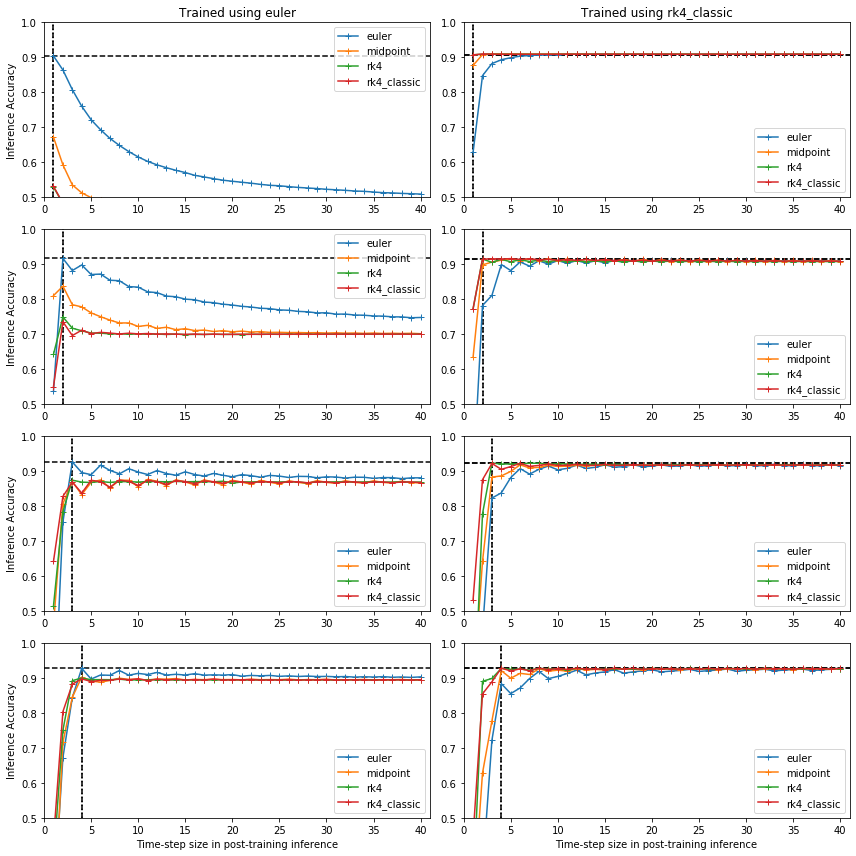

In [112]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if args.use_skip_init: continue
    cols.append(args.final_time_d)
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if args.use_skip_init: continue
    print(name)
    col = cols[args.final_time_d]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme == args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.5,1.0)
    plt.xlim(0,41)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()

This creates the plot for all of the backprops

## SkipInit

{2: 0, 4: 1, 6: 2, 8: 3, 12: 4}
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-12-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.p

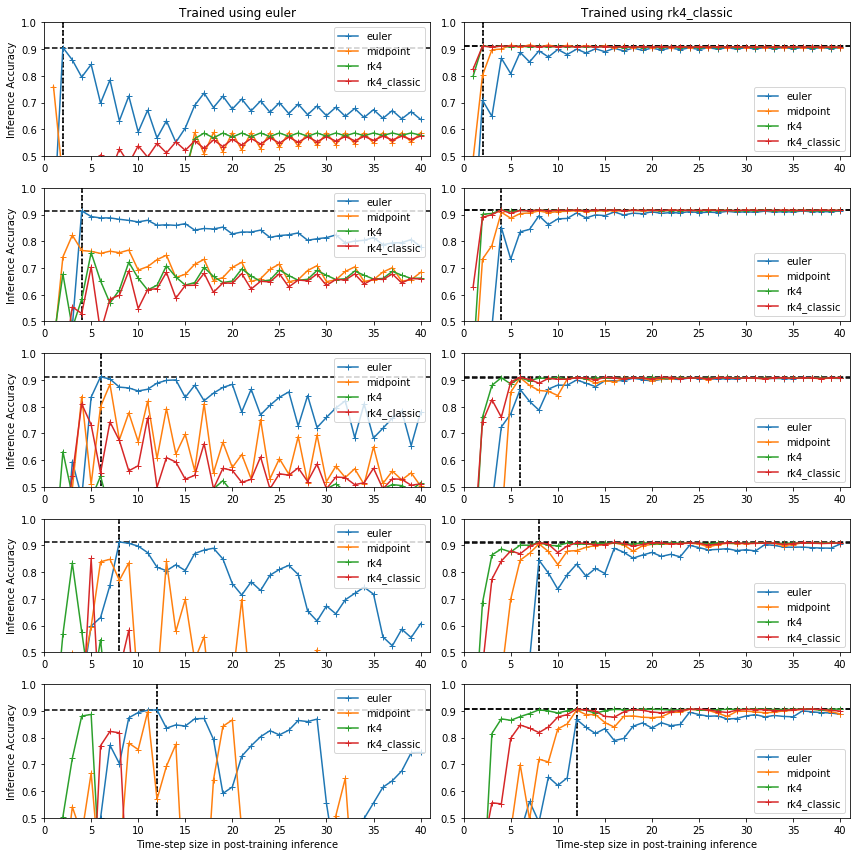

In [113]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if not args.use_skip_init: continue
    cols.append(args.final_time_d)
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if not args.use_skip_init: continue
    print(name)
    col = cols[args.final_time_d]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme == args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.5,1.0)
    plt.xlim(0,41)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()

## Refinement + BatchNorm

{(10, 20, 30): 0, (10, 20, 30, 40, 50): 1, (10, 20, 40, 60): 2, (20, 30, 40): 3, (20, 40, 60, 70, 80): 4, (30, 40): 5, (30, 45, 60): 6, (30, 60): 7, (40, 80): 8, (45, 60): 9, (50, 100): 10, (60, 120): 11}
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[20, 30, 40]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[30, 45, 60]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-[30, 40]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEA

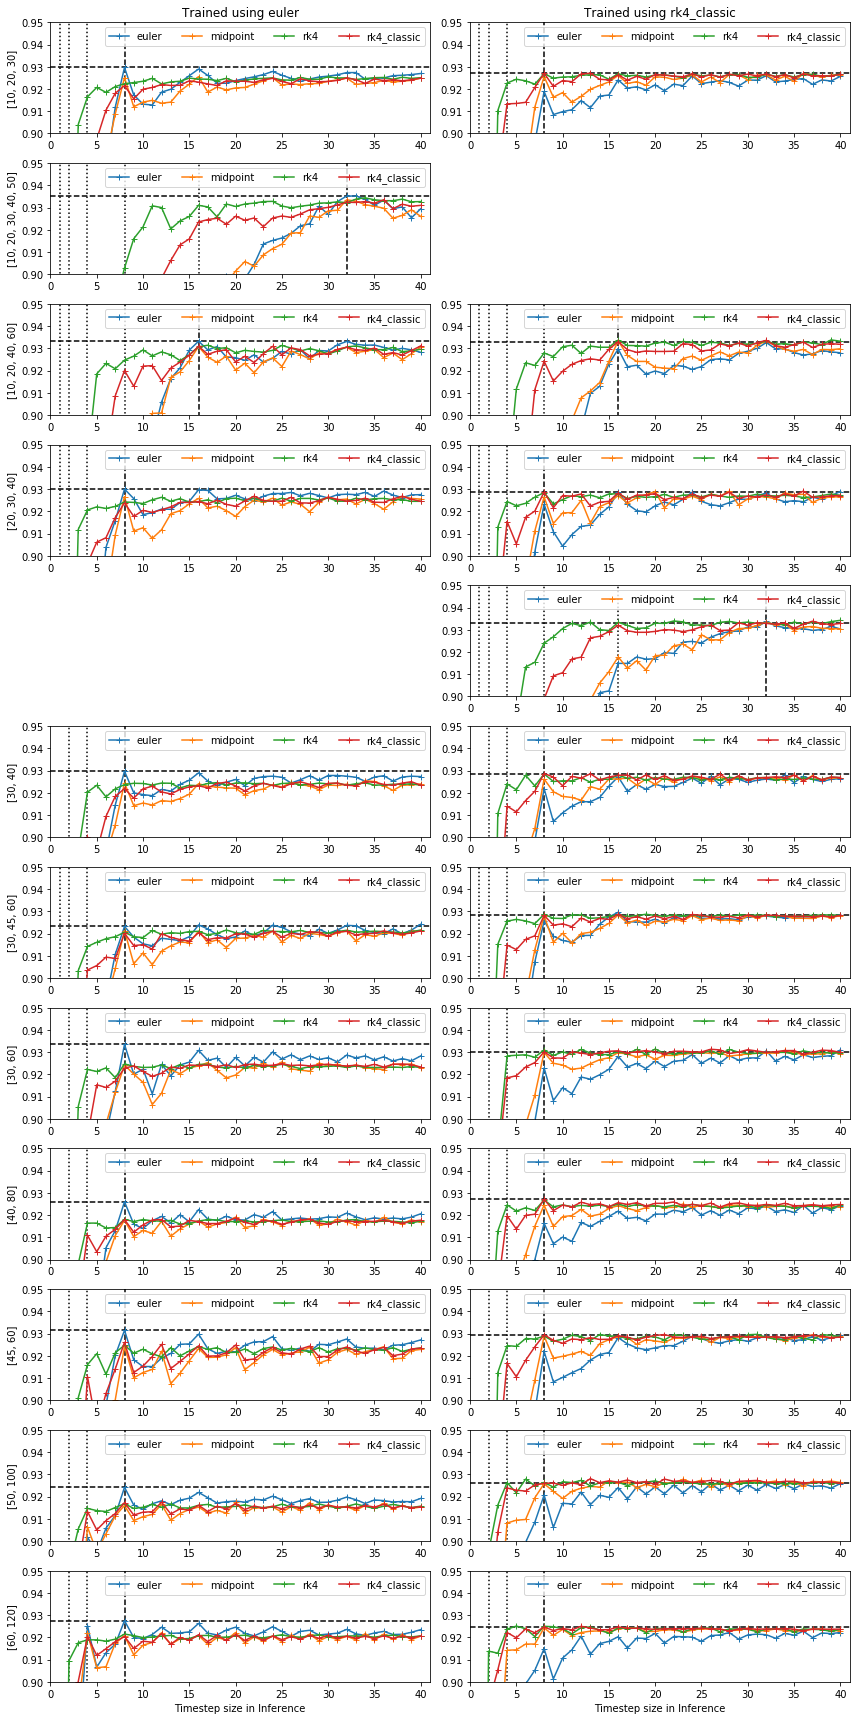

In [153]:
plt.figure(figsize=(12,24))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if args.use_skip_init: continue
    if "Wide" in args.model: continue
    cols.append(tuple(args.refine))
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if args.use_skip_init: continue
    if "Wide" in args.model: continue
    print(name)
    col = cols[tuple(args.refine)]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme == args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d*2**i for i in range(len(args.refine))],
               0, 1, linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.9,0.95)
    plt.xlim(0,41)
    plt.legend(ncol=4)
    if col == max(cols.values()):
        plt.xlabel(f'Timestep size in Inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel(f'{args.refine}')
plt.tight_layout()
plt.show()

## Refinement + SkipInit

{(40, 60): 0, (40, 100): 1, (90, 130): 2}
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[40, 60]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 60]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl


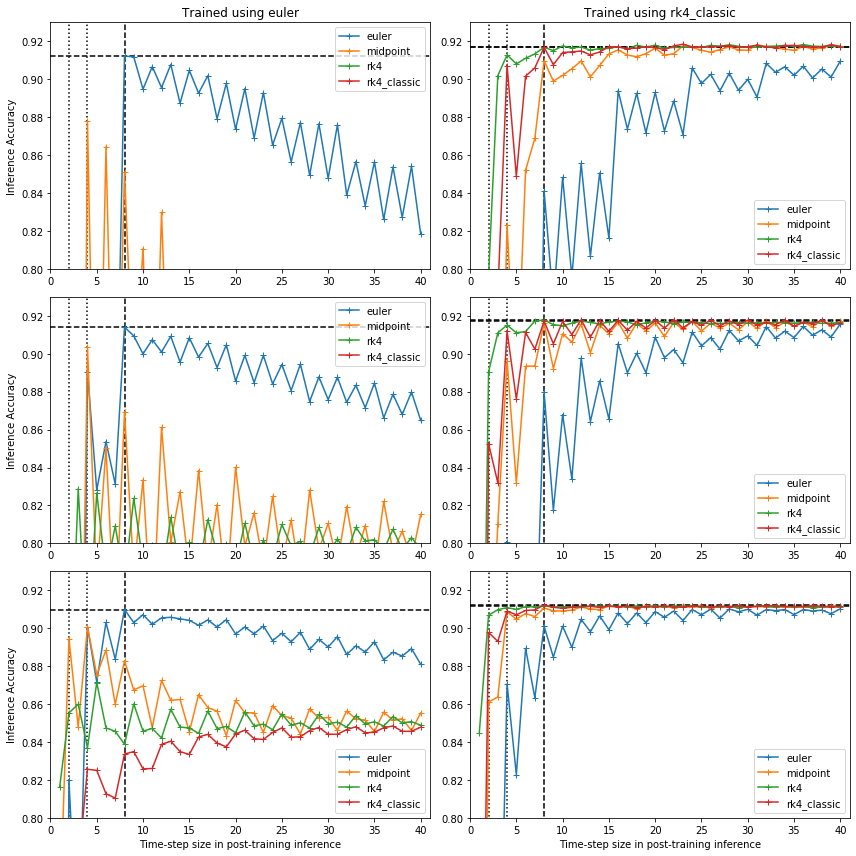

In [133]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if not args.use_skip_init: continue
    cols.append(tuple(args.refine))

cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if not args.use_skip_init: continue
    print(name)
    col = cols[tuple(args.refine)]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    plt.vlines([args.initial_time_d*2**i for i in range(len(args.refine))],
               0, 1, linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.8,0.93)
    plt.xlim(0,41)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()